# Cross-Lingual Unlearning


In [1]:
!pip install -q transformers==4.36.0 lightning==2.1.3 torchmetrics pandas matplotlib
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch
torch.set_float32_matmul_precision('high')
torch.cuda.empty_cache()
!nvidia-smi --query-gpu=name,memory.total --format=csv
print("✅ Setup complete")

name, memory.total [MiB]
NVIDIA L4, 23034 MiB
✅ Setup complete


/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


In [2]:
import json, random, copy, gc
from typing import List
from dataclasses import dataclass
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, Callback
from transformers import AutoModelForCausalLM, AutoTokenizer, get_linear_schedule_with_warmup
print("✅ Imports")

/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


✅ Imports


In [3]:
@dataclass
class Config:
    model_name: str = "facebook/xglm-564M"
    languages: List[str] = None
    data_dir: str = "/content/data"
    output_dir: str = "/content/ckpts"
    cache_dir: str = "/content/cache"

    forget_num: int = 200
    retain_multiplier: int = 5
    max_seq_len: int = 256

    # CORRECTED: Less aggressive unlearning
    learning_rate: float = 1e-4  # Reduced from 5e-4
    warmup_ratio: float = 0.1
    temperature: float = 1.0
    lambda_forget: float = 0.3  # Scale down forget loss (gradient ascent)

    per_device_train_batch_size: int = 4
    per_device_eval_batch_size: int = 2
    gradient_accumulation_steps: int = 8

    max_epochs: int = 20  # More epochs for gradual forgetting
    forget_every_n_epochs: int = 4  # Forget every 4th epoch (0,4,8,12...)

    num_workers: int = 2
    seed: int = 42
    ma_max_samples: int = 10
    ma_stride: int = 16

    def __post_init__(self):
        if self.languages is None:
            self.languages = ["hi","bn","te","ta","mr","gu","kn","ml","pa","ur","or","as","sd","bho","mai","san","kas_ar","kas_de"]

config = Config()
for d in [config.data_dir, config.output_dir, config.cache_dir]:
    os.makedirs(d, exist_ok=True)
L.seed_everything(config.seed)
print(f"Model: {config.model_name}")
print(f"LR: {config.learning_rate} (less aggressive)")
print(f"Forget schedule: Every {config.forget_every_n_epochs} epochs")
print(f"Lambda forget: {config.lambda_forget} (scaled down)")
print(f"Max epochs: {config.max_epochs}")
print("✅ Config")

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Model: facebook/xglm-564M
LR: 0.0001 (less aggressive)
Forget schedule: Every 4 epochs
Lambda forget: 0.3 (scaled down)
Max epochs: 20
✅ Config


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from google.colab import files
print("Upload: forget-200.jsonl, retain-200-x5.jsonl, test.jsonl, valid.jsonl")
uploaded = files.upload()
for f in uploaded:
    os.rename(f, os.path.join(config.data_dir, f))
print("✅ Uploaded")

Upload: forget-200.jsonl, retain-200-x5.jsonl, test.jsonl, valid.jsonl


Saving forget-200.jsonl to forget-200.jsonl
Saving retain-200-x5.jsonl to retain-200-x5.jsonl
Saving test.jsonl to test.jsonl
Saving valid.jsonl to valid.jsonl
✅ Uploaded


In [6]:
class FLORESDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=256, languages=["hi"]):
        self.data, self.tokenizer, self.max_len, self.languages = data, tokenizer, max_len, languages
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        lang = random.choice(self.languages) if len(self.languages)>1 else self.languages[0]
        enc = self.tokenizer(self.data[idx][lang], max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt")
        labels = enc["input_ids"].clone()
        labels[labels==self.tokenizer.pad_token_id] = -100
        return {"input_ids":enc["input_ids"].squeeze(0), "attention_mask":enc["attention_mask"].squeeze(0), "labels":labels.squeeze(0)}

class FLORESDataModule(L.LightningDataModule):
    def __init__(self, cfg, tok):
        super().__init__()
        self.cfg, self.tok = cfg, tok
    def load(self, f): return [json.loads(l) for l in open(f"{self.cfg.data_dir}/{f}")]
    def setup(self, stage=None):
        if stage=="fit" or stage is None:
            fd = self.load(f"forget-{self.cfg.forget_num}.jsonl")
            rd = self.load(f"retain-{self.cfg.forget_num}-x{self.cfg.retain_multiplier}.jsonl")
            vd = self.load("valid.jsonl")
            self.forget = FLORESDataset(fd, self.tok, self.cfg.max_seq_len, self.cfg.languages)
            self.retain = FLORESDataset(rd, self.tok, self.cfg.max_seq_len, self.cfg.languages)
            self.valid = []
            for lang in self.cfg.languages:
                self.valid.append(FLORESDataset(vd, self.tok, self.cfg.max_seq_len, [lang]))
                self.valid.append(FLORESDataset(fd, self.tok, self.cfg.max_seq_len, [lang]))
        if stage=="test" or stage is None:
            fd = self.load(f"forget-{self.cfg.forget_num}.jsonl")
            td = self.load("test.jsonl")
            self.test = []
            for lang in self.cfg.languages:
                self.test.append(FLORESDataset(td, self.tok, self.cfg.max_seq_len, [lang]))
                self.test.append(FLORESDataset(fd, self.tok, self.cfg.max_seq_len, [lang]))
    def train_dataloader(self):
        # CORRECTED: Forget every N epochs, otherwise retain
        is_forget_epoch = self.trainer.current_epoch % self.cfg.forget_every_n_epochs == 0
        ds = self.forget if is_forget_epoch else self.retain
        return DataLoader(ds, batch_size=self.cfg.per_device_train_batch_size, num_workers=self.cfg.num_workers, shuffle=True, pin_memory=True)
    def val_dataloader(self):
        return [DataLoader(d, batch_size=self.cfg.per_device_eval_batch_size, num_workers=self.cfg.num_workers, shuffle=False, pin_memory=True) for d in self.valid]
    def test_dataloader(self):
        return [DataLoader(d, batch_size=self.cfg.per_device_eval_batch_size, num_workers=self.cfg.num_workers, shuffle=False, pin_memory=True) for d in self.test]

print("✅ Dataset")

✅ Dataset


In [7]:
class Model(L.LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.save_hyperparameters()
        self.tok = AutoTokenizer.from_pretrained(cfg.model_name, cache_dir=cfg.cache_dir)
        if self.tok.pad_token is None: self.tok.pad_token = self.tok.eos_token
        self.model = AutoModelForCausalLM.from_pretrained(cfg.model_name, cache_dir=cfg.cache_dir)
        self.model.gradient_checkpointing_enable()
        self.teacher = copy.deepcopy(self.model)
        self.teacher.eval()
        for p in self.teacher.parameters(): p.requires_grad=False
        self.vnames = [f"val/{l}_{t}_" for l in cfg.languages for t in ["valid","forget"]]
        self.tnames = [f"test/{l}_{t}_" for l in cfg.languages for t in ["test","forget"]]
        self.val_ma_correct, self.val_ma_total = [], []
        self.test_ma_correct, self.test_ma_total = [], []

    def forward(self, **x): return self.model(**x)

    def training_step(self, batch, batch_idx):
        out = self(**batch)
        loss = out.loss
        # CORRECTED: Check if this is a forget epoch
        is_forget = self.current_epoch % self.cfg.forget_every_n_epochs == 0

        if is_forget:
            # Gradient ascent with scaling
            loss = -loss * self.cfg.lambda_forget  # Scale down
            self.log("train/forget_loss", loss, prog_bar=True)
        else:
            # Retention with KD
            logit_s = out.logits
            mask = batch["labels"].eq(-100)
            with torch.no_grad():
                logit_t = self.teacher(**batch).logits
            prob_t = F.softmax(logit_t, dim=-1)
            lbl = torch.clamp(batch["labels"], min=0)
            pt = prob_t.gather(-1, lbl.unsqueeze(-1))
            pt.masked_fill_(mask.unsqueeze(-1), 0)
            kappa = (pt.sum()/(~mask).sum()).clamp(0,1)
            lkd = F.kl_div(F.log_softmax(logit_s/self.cfg.temperature,-1), F.softmax(logit_t/self.cfg.temperature,-1), reduction="batchmean")*(self.cfg.temperature**2)
            del logit_t, prob_t
            loss = kappa*lkd + (1-kappa)*loss
            self.log_dict({"train/loss":loss,"train/kd":lkd,"train/kappa":kappa}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        loss = self(**batch).loss
        ppl = torch.exp(loss.clamp(max=10))
        name = self.vnames[dataloader_idx] if dataloader_idx<len(self.vnames) else f"val/unk{dataloader_idx}_"
        corr, tot = self._ma_counts(batch)
        while len(self.val_ma_correct) <= dataloader_idx:
            self.val_ma_correct.append(0)
            self.val_ma_total.append(0)
        self.val_ma_correct[dataloader_idx] += corr
        self.val_ma_total[dataloader_idx] += tot
        self.log_dict({f"{name}ppl":ppl, f"{name}loss":loss}, add_dataloader_idx=False)
        torch.cuda.empty_cache()
        return loss

    def test_step(self, batch, batch_idx, dataloader_idx=0):
        loss = self(**batch).loss
        ppl = torch.exp(loss.clamp(max=10))
        name = self.tnames[dataloader_idx] if dataloader_idx<len(self.tnames) else f"test/unk{dataloader_idx}_"
        corr, tot = self._ma_counts(batch)
        while len(self.test_ma_correct) <= dataloader_idx:
            self.test_ma_correct.append(0)
            self.test_ma_total.append(0)
        self.test_ma_correct[dataloader_idx] += corr
        self.test_ma_total[dataloader_idx] += tot
        self.log_dict({f"{name}ppl":ppl, f"{name}loss":loss}, add_dataloader_idx=False)
        torch.cuda.empty_cache()
        return loss

    @torch.no_grad()
    def _ma_counts(self, batch):
        try:
            bs = batch["input_ids"].size(0)
            if bs > self.cfg.ma_max_samples:
                idx = torch.randperm(bs, device=batch["input_ids"].device)[:self.cfg.ma_max_samples]
                batch = {k:v[idx] if torch.is_tensor(v) else v for k,v in batch.items()}
            corr, tot = 0, 0
            for pos in range(self.cfg.ma_stride, self.cfg.max_seq_len, self.cfg.ma_stride):
                lbl = batch["labels"][...,pos]
                if (lbl==-100).all(): break
                out = self.model(input_ids=batch["input_ids"][...,:pos], attention_mask=batch["attention_mask"][...,:pos])
                pred = out.logits[:,-1,:].argmax(-1)
                valid = lbl!=-100
                corr += ((pred==lbl)&valid).sum().item()
                tot += valid.sum().item()
                del out
                if pos%(self.cfg.ma_stride*3)==0: torch.cuda.empty_cache()
            torch.cuda.empty_cache()
            return corr, tot
        except: return 0, 1

    def on_validation_epoch_end(self):
        for i, (c, t) in enumerate(zip(self.val_ma_correct, self.val_ma_total)):
            if t>0:
                self.log(f"{self.vnames[i] if i<len(self.vnames) else f'val/unk{i}_'}ma", c/t)
        fidx = [i for i,n in enumerate(self.vnames) if "forget" in n]
        if fidx:
            tc = sum(self.val_ma_correct[i] for i in fidx)
            tt = sum(self.val_ma_total[i] for i in fidx)
            if tt>0:
                fma = tc/tt
                self.log("val/forget_xma", fma)
                print(f"\n📊 Epoch {self.current_epoch} Forget MA: {fma:.2%}")
        self.val_ma_correct, self.val_ma_total = [], []
        m = self.trainer.logged_metrics
        fppl = [v for k,v in m.items() if "ppl" in k and "forget" in k]
        if fppl: self.log("val/forget_xppl", torch.stack(fppl).mean())
        torch.cuda.empty_cache(); gc.collect()

    def on_test_epoch_end(self):
        for i, (c,t) in enumerate(zip(self.test_ma_correct, self.test_ma_total)):
            if t>0:
                self.log(f"{self.tnames[i] if i<len(self.tnames) else f'test/unk{i}_'}ma", c/t)
        self.test_ma_correct, self.test_ma_total = [], []

    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.model.parameters(), lr=self.cfg.learning_rate)
        sch = get_linear_schedule_with_warmup(opt, int(self.cfg.warmup_ratio*self.trainer.estimated_stepping_batches), self.trainer.estimated_stepping_batches)
        return {"optimizer":opt, "lr_scheduler":{"scheduler":sch,"interval":"step"}}

print("✅ Model")

✅ Model


In [8]:
class CB(Callback):
    def __init__(self, out): self.out = out
    def on_test_epoch_end(self, trainer, _):
        pd.DataFrame({k.replace("test/",""):[v.item()] for k,v in trainer.logged_metrics.items()}).to_csv(f"{self.out}/test.csv", index=False)

tok = AutoTokenizer.from_pretrained(config.model_name, cache_dir=config.cache_dir)
if tok.pad_token is None: tok.pad_token = tok.eos_token
dm = FLORESDataModule(config, tok)
dm.setup("fit")
print(f"Forget:{len(dm.forget)} Retain:{len(dm.retain)} Valid:{len(dm.valid)}")
model = Model(config)
print(f"Params: {sum(p.numel() for p in model.model.parameters())/1e6:.0f}M")
ckpt = ModelCheckpoint(config.output_dir, "e{epoch:02d}-fma{val/forget_xma:.3f}", "val/forget_xma", "min", save_top_k=2, save_weights_only=True)
trainer = L.Trainer(default_root_dir=config.output_dir, accelerator="gpu", devices=1, precision="bf16-mixed", max_epochs=config.max_epochs,
                    accumulate_grad_batches=config.gradient_accumulation_steps, gradient_clip_val=1.0,
                    callbacks=[ckpt, CB(config.output_dir)], reload_dataloaders_every_n_epochs=1, num_sanity_val_steps=0)
print("✅ Ready")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Forget:200 Retain:1000 Valid:36


/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.util

Params: 564M
✅ Ready


In [9]:
print("="*80)
print("🚀 TRAINING (Corrected for 25-30% MA)")
print("="*80)
print(f"Forget every {config.forget_every_n_epochs} epochs (0, 4, 8, 12...)")
print(f"Retain on other epochs (1,2,3, 5,6,7, 9,10,11...)")
print(f"Lambda forget: {config.lambda_forget} (scaled down gradient ascent)")
print("="*80 + "\n")
trainer.fit(model, dm)
print("\n"+"="*80)
print("✅ DONE")
print("="*80)

🚀 TRAINING (Corrected for 25-30% MA)
Forget every 4 epochs (0, 4, 8, 12...)
Retain on other epochs (1,2,3, 5,6,7, 9,10,11...)
Lambda forget: 0.3 (scaled down gradient ascent)



/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /content/ckpts exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loading `train_dataloader` to estimate number of stepping batches.
INFO:lightning.pytorch.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.
INFO: 
  | Name    | Type            | Params
--------------------------------------------
0 | model   | XGLMForCausalLM | 564 M 
1 | teacher | XGLMForCausalLM | 564 M 
--------------------------------------------
564 M     Trainable params
564 M     Non-trainable params
1.1 B     Total params
4,515.709 Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type            | Params
--------------------------------------------
0 | model   | XGLMForCausalLM | 564 M 
1 | teacher | XGL

Training: |          | 0/? [00:00<?, ?it/s]

`use_cache = True` is incompatible with gradient checkpointing`. Setting `use_cache = False`...
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Validation: |          | 0/? [00:00<?, ?it/s]


📊 Epoch 0 Forget MA: 13.50%


INFO: Epoch 0, global step 7: 'val/forget_xma' reached 0.13497 (best 0.13497), saving model to '/content/ckpts/eepoch=00-fmaval/forget_xma=0.135-v1.ckpt' as top 2
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 7: 'val/forget_xma' reached 0.13497 (best 0.13497), saving model to '/content/ckpts/eepoch=00-fmaval/forget_xma=0.135-v1.ckpt' as top 2
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]


📊 Epoch 1 Forget MA: 15.86%


INFO: Epoch 1, global step 39: 'val/forget_xma' reached 0.15857 (best 0.13497), saving model to '/content/ckpts/eepoch=01-fmaval/forget_xma=0.159-v1.ckpt' as top 2
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 39: 'val/forget_xma' reached 0.15857 (best 0.13497), saving model to '/content/ckpts/eepoch=01-fmaval/forget_xma=0.159-v1.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]


📊 Epoch 2 Forget MA: 16.88%


INFO: Epoch 2, global step 71: 'val/forget_xma' was not in top 2
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 71: 'val/forget_xma' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]


📊 Epoch 3 Forget MA: 17.34%


INFO: Epoch 3, global step 103: 'val/forget_xma' was not in top 2
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 103: 'val/forget_xma' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]


📊 Epoch 4 Forget MA: 16.30%


INFO: Epoch 4, global step 110: 'val/forget_xma' was not in top 2
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 110: 'val/forget_xma' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]


📊 Epoch 5 Forget MA: 17.29%


INFO: Epoch 5, global step 142: 'val/forget_xma' was not in top 2
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 142: 'val/forget_xma' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]


📊 Epoch 6 Forget MA: 17.29%


INFO: Epoch 6, global step 174: 'val/forget_xma' was not in top 2
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 174: 'val/forget_xma' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]


📊 Epoch 7 Forget MA: 17.29%


INFO: Epoch 7, global step 206: 'val/forget_xma' was not in top 2
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 206: 'val/forget_xma' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]


📊 Epoch 8 Forget MA: 17.29%


INFO: Epoch 8, global step 213: 'val/forget_xma' was not in top 2
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 213: 'val/forget_xma' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]


📊 Epoch 9 Forget MA: 17.29%


INFO: Epoch 9, global step 245: 'val/forget_xma' was not in top 2
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 245: 'val/forget_xma' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]


📊 Epoch 10 Forget MA: 17.29%


INFO: Epoch 10, global step 277: 'val/forget_xma' was not in top 2
INFO:lightning.pytorch.utilities.rank_zero:Epoch 10, global step 277: 'val/forget_xma' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]


📊 Epoch 11 Forget MA: 17.29%


INFO: Epoch 11, global step 309: 'val/forget_xma' was not in top 2
INFO:lightning.pytorch.utilities.rank_zero:Epoch 11, global step 309: 'val/forget_xma' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]


📊 Epoch 12 Forget MA: 17.29%


INFO: Epoch 12, global step 316: 'val/forget_xma' was not in top 2
INFO:lightning.pytorch.utilities.rank_zero:Epoch 12, global step 316: 'val/forget_xma' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]


📊 Epoch 13 Forget MA: 17.29%


INFO: Epoch 13, global step 348: 'val/forget_xma' was not in top 2
INFO:lightning.pytorch.utilities.rank_zero:Epoch 13, global step 348: 'val/forget_xma' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]


📊 Epoch 14 Forget MA: 17.29%


INFO: Epoch 14, global step 380: 'val/forget_xma' was not in top 2
INFO:lightning.pytorch.utilities.rank_zero:Epoch 14, global step 380: 'val/forget_xma' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]


📊 Epoch 15 Forget MA: 17.29%


INFO: Epoch 15, global step 412: 'val/forget_xma' was not in top 2
INFO:lightning.pytorch.utilities.rank_zero:Epoch 15, global step 412: 'val/forget_xma' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]


📊 Epoch 16 Forget MA: 17.29%


INFO: Epoch 16, global step 419: 'val/forget_xma' was not in top 2
INFO:lightning.pytorch.utilities.rank_zero:Epoch 16, global step 419: 'val/forget_xma' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]


📊 Epoch 17 Forget MA: 17.29%


INFO: Epoch 17, global step 451: 'val/forget_xma' was not in top 2
INFO:lightning.pytorch.utilities.rank_zero:Epoch 17, global step 451: 'val/forget_xma' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]


📊 Epoch 18 Forget MA: 17.29%


INFO: Epoch 18, global step 483: 'val/forget_xma' was not in top 2
INFO:lightning.pytorch.utilities.rank_zero:Epoch 18, global step 483: 'val/forget_xma' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]


📊 Epoch 19 Forget MA: 17.29%


INFO: Epoch 19, global step 515: 'val/forget_xma' was not in top 2
INFO:lightning.pytorch.utilities.rank_zero:Epoch 19, global step 515: 'val/forget_xma' was not in top 2
INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.



✅ DONE


In [11]:
import torch

# Allow Config class to be unpickled
torch.serialization.add_safe_globals([Config])

# Now load checkpoint
print("📊 TESTING")
best = Model.load_from_checkpoint(ckpt.best_model_path, cfg=config)
dm.setup("test")
trainer.test(best, dm)
print("✅ Done")

📊 TESTING


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/as_forget_loss    │                           │                           │                           │
│     test/as_forget_ma     │    0.10071942210197449    │    0.10071942210197449    │    0.10071942210197449    │
│    test/as_forget_ppl     │                           │                           │                           │
│     test/as_test_loss     │                           │                           │                           │
│      test/as_test_ma      │    0.10705596208572388    │    0.10705596208572388    │    0.10705596208572388    │
│     test/as_test_ppl      │                           │                           │                           │
│   test/bho_forget_loss    │                           │                           │                           │
│    test/bho_forget_ma     │    0.16701461374759674    │    0.16701461374759674    │    0.16701461374759674    │
│    test/bho_forget_ppl    │                           │                           │                           │
│    test/bho_test_loss     │                           │                           │                           │
│     test/bho_test_ma      │    0.15263909101486206    │    0.15263909101486206    │    0.15263909101486206    │
│     test/bho_test_ppl     │                           │                           │                           │
│    test/bn_forget_loss    │                           │                           │                           │
│     test/bn_forget_ma     │    0.33560091257095337    │    0.33560091257095337    │    0.33560091257095337    │
│    test/bn_forget_ppl     │                           │                           │                           │
│     test/bn_test_loss     │                           │                           │     5.114274024963379     │
│      test/bn_test_ma      │    0.3328358232975006     │    0.3328358232975006     │    0.3328358232975006     │
│     test/bn_test_ppl      │                           │                           │     211.2152099609375     │
│    test/gu_forget_loss    │                           │                           │                           │
│     test/gu_forget_ma     │   0.0062761506997048855   │   0.0062761506997048855   │   0.0062761506997048855   │
│    test/gu_forget_ppl     │                           │                           │                           │
│     test/gu_test_loss     │                           │                           │                           │
│      test/gu_test_ma      │   0.023943662643432617    │   0.023943662643432617    │   0.023943662643432617    │
│     test/gu_test_ppl      │                           │                           │                           │
│    test/hi_forget_loss    │                           │     5.057002067565918     │                           │
│     test/hi_forget_ma     │    0.3842364549636841     │    0.3842364549636841     │    0.3842364549636841     │
│    test/hi_forget_ppl     │                           │    198.88783264160156     │                           │
│     test/hi_test_loss     │     5.180604934692383     │                           │                           │
│      test/hi_test_ma      │    0.38030558824539185    │    0.38030558824539185    │    0.38030558824539185    │
│     test/hi_test_ppl      │    227.05618286132812     │                           │                           │
│  test/kas_ar_forget_loss  │                           │                           │                           │
│   test/kas_ar_forget_ma   │    0.13476262986660004    │    0.13476262986660004    │    0.13476262986660004    │
│  test/ka

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 3        ┃       DataLoader 4        ┃       DataLoader 5        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/as_forget_loss    │                           │                           │                           │
│     test/as_forget_ma     │    0.10071942210197449    │    0.10071942210197449    │    0.10071942210197449    │
│    test/as_forget_ppl     │                           │                           │                           │
│     test/as_test_loss     │                           │                           │                           │
│      test/as_test_ma      │    0.10705596208572388    │    0.10705596208572388    │    0.10705596208572388    │
│     test/as_test_ppl      │                           │                           │                           │
│   test/bho_forget_loss    │                           │                           │                           │
│    test/bho_forget_ma     │    0.16701461374759674    │    0.16701461374759674    │    0.16701461374759674    │
│    test/bho_forget_ppl    │                           │                           │                           │
│    test/bho_test_loss     │                           │                           │                           │
│     test/bho_test_ma      │    0.15263909101486206    │    0.15263909101486206    │    0.15263909101486206    │
│     test/bho_test_ppl     │                           │                           │                           │
│    test/bn_forget_loss    │      5.1325364112854      │                           │                           │
│     test/bn_forget_ma     │    0.33560091257095337    │    0.33560091257095337    │    0.33560091257095337    │
│    test/bn_forget_ppl     │    228.06948852539062     │                           │                           │
│     test/bn_test_loss     │                           │                           │                           │
│      test/bn_test_ma      │    0.3328358232975006     │    0.3328358232975006     │    0.3328358232975006     │
│     test/bn_test_ppl      │                           │                           │                           │
│    test/gu_forget_loss    │                           │                           │                           │
│     test/gu_forget_ma     │   0.0062761506997048855   │   0.0062761506997048855   │   0.0062761506997048855   │
│    test/gu_forget_ppl     │                           │                           │                           │
│     test/gu_test_loss     │                           │                           │                           │
│      test/gu_test_ma      │   0.023943662643432617    │   0.023943662643432617    │   0.023943662643432617    │
│     test/gu_test_ppl      │                           │                           │                           │
│    test/hi_forget_loss    │                           │                           │                           │
│     test/hi_forget_ma     │    0.3842364549636841     │    0.3842364549636841     │    0.3842364549636841     │
│    test/hi_forget_ppl     │                           │                           │                           │
│     test/hi_test_loss     │                           │                           │                           │
│      test/hi_test_ma      │    0.38030558824539185    │    0.38030558824539185    │    0.38030558824539185    │
│     test/hi_test_ppl      │                           │                           │                           │
│  test/kas_ar_forget_loss  │                           │                           │                           │
│   test/kas_ar_forget_ma   │    0.13476262986660004    │    0.13476262986660004    │    0.13476262986660004    │
│  test/ka

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 6        ┃       DataLoader 7        ┃       DataLoader 8        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/as_forget_loss    │                           │                           │                           │
│     test/as_forget_ma     │    0.10071942210197449    │    0.10071942210197449    │    0.10071942210197449    │
│    test/as_forget_ppl     │                           │                           │                           │
│     test/as_test_loss     │                           │                           │                           │
│      test/as_test_ma      │    0.10705596208572388    │    0.10705596208572388    │    0.10705596208572388    │
│     test/as_test_ppl      │                           │                           │                           │
│   test/bho_forget_loss    │                           │                           │                           │
│    test/bho_forget_ma     │    0.16701461374759674    │    0.16701461374759674    │    0.16701461374759674    │
│    test/bho_forget_ppl    │                           │                           │                           │
│    test/bho_test_loss     │                           │                           │                           │
│     test/bho_test_ma      │    0.15263909101486206    │    0.15263909101486206    │    0.15263909101486206    │
│     test/bho_test_ppl     │                           │                           │                           │
│    test/bn_forget_loss    │                           │                           │                           │
│     test/bn_forget_ma     │    0.33560091257095337    │    0.33560091257095337    │    0.33560091257095337    │
│    test/bn_forget_ppl     │                           │                           │                           │
│     test/bn_test_loss     │                           │                           │                           │
│      test/bn_test_ma      │    0.3328358232975006     │    0.3328358232975006     │    0.3328358232975006     │
│     test/bn_test_ppl      │                           │                           │                           │
│    test/gu_forget_loss    │                           │                           │                           │
│     test/gu_forget_ma     │   0.0062761506997048855   │   0.0062761506997048855   │   0.0062761506997048855   │
│    test/gu_forget_ppl     │                           │                           │                           │
│     test/gu_test_loss     │                           │                           │                           │
│      test/gu_test_ma      │   0.023943662643432617    │   0.023943662643432617    │   0.023943662643432617    │
│     test/gu_test_ppl      │                           │                           │                           │
│    test/hi_forget_loss    │                           │                           │                           │
│     test/hi_forget_ma     │    0.3842364549636841     │    0.3842364549636841     │    0.3842364549636841     │
│    test/hi_forget_ppl     │                           │                           │                           │
│     test/hi_test_loss     │                           │                           │                           │
│      test/hi_test_ma      │    0.38030558824539185    │    0.38030558824539185    │    0.38030558824539185    │
│     test/hi_test_ppl      │                           │                           │                           │
│  test/kas_ar_forget_loss  │                           │                           │                           │
│   test/kas_ar_forget_ma   │    0.13476262986660004    │    0.13476262986660004    │    0.13476262986660004    │
│  test/ka

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 9        ┃       DataLoader 10       ┃       DataLoader 11       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/as_forget_loss    │                           │                           │                           │
│     test/as_forget_ma     │    0.10071942210197449    │    0.10071942210197449    │    0.10071942210197449    │
│    test/as_forget_ppl     │                           │                           │                           │
│     test/as_test_loss     │                           │                           │                           │
│      test/as_test_ma      │    0.10705596208572388    │    0.10705596208572388    │    0.10705596208572388    │
│     test/as_test_ppl      │                           │                           │                           │
│   test/bho_forget_loss    │                           │                           │                           │
│    test/bho_forget_ma     │    0.16701461374759674    │    0.16701461374759674    │    0.16701461374759674    │
│    test/bho_forget_ppl    │                           │                           │                           │
│    test/bho_test_loss     │                           │                           │                           │
│     test/bho_test_ma      │    0.15263909101486206    │    0.15263909101486206    │    0.15263909101486206    │
│     test/bho_test_ppl     │                           │                           │                           │
│    test/bn_forget_loss    │                           │                           │                           │
│     test/bn_forget_ma     │    0.33560091257095337    │    0.33560091257095337    │    0.33560091257095337    │
│    test/bn_forget_ppl     │                           │                           │                           │
│     test/bn_test_loss     │                           │                           │                           │
│      test/bn_test_ma      │    0.3328358232975006     │    0.3328358232975006     │    0.3328358232975006     │
│     test/bn_test_ppl      │                           │                           │                           │
│    test/gu_forget_loss    │                           │                           │    34.442405700683594     │
│     test/gu_forget_ma     │   0.0062761506997048855   │   0.0062761506997048855   │   0.0062761506997048855   │
│    test/gu_forget_ppl     │                           │                           │       22026.4765625       │
│     test/gu_test_loss     │                           │       34.419921875        │                           │
│      test/gu_test_ma      │   0.023943662643432617    │   0.023943662643432617    │   0.023943662643432617    │
│     test/gu_test_ppl      │                           │       22026.484375        │                           │
│    test/hi_forget_loss    │                           │                           │                           │
│     test/hi_forget_ma     │    0.3842364549636841     │    0.3842364549636841     │    0.3842364549636841     │
│    test/hi_forget_ppl     │                           │                           │                           │
│     test/hi_test_loss     │                           │                           │                           │
│      test/hi_test_ma      │    0.38030558824539185    │    0.38030558824539185    │    0.38030558824539185    │
│     test/hi_test_ppl      │                           │                           │                           │
│  test/kas_ar_forget_loss  │                           │                           │                           │
│   test/kas_ar_forget_ma   │    0.13476262986660004    │    0.13476262986660004    │    0.13476262986660004    │
│  test/ka

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 12       ┃       DataLoader 13       ┃       DataLoader 14       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/as_forget_loss    │                           │                           │                           │
│     test/as_forget_ma     │    0.10071942210197449    │    0.10071942210197449    │    0.10071942210197449    │
│    test/as_forget_ppl     │                           │                           │                           │
│     test/as_test_loss     │                           │                           │                           │
│      test/as_test_ma      │    0.10705596208572388    │    0.10705596208572388    │    0.10705596208572388    │
│     test/as_test_ppl      │                           │                           │                           │
│   test/bho_forget_loss    │                           │                           │                           │
│    test/bho_forget_ma     │    0.16701461374759674    │    0.16701461374759674    │    0.16701461374759674    │
│    test/bho_forget_ppl    │                           │                           │                           │
│    test/bho_test_loss     │                           │                           │                           │
│     test/bho_test_ma      │    0.15263909101486206    │    0.15263909101486206    │    0.15263909101486206    │
│     test/bho_test_ppl     │                           │                           │                           │
│    test/bn_forget_loss    │                           │                           │                           │
│     test/bn_forget_ma     │    0.33560091257095337    │    0.33560091257095337    │    0.33560091257095337    │
│    test/bn_forget_ppl     │                           │                           │                           │
│     test/bn_test_loss     │                           │                           │                           │
│      test/bn_test_ma      │    0.3328358232975006     │    0.3328358232975006     │    0.3328358232975006     │
│     test/bn_test_ppl      │                           │                           │                           │
│    test/gu_forget_loss    │                           │                           │                           │
│     test/gu_forget_ma     │   0.0062761506997048855   │   0.0062761506997048855   │   0.0062761506997048855   │
│    test/gu_forget_ppl     │                           │                           │                           │
│     test/gu_test_loss     │                           │                           │                           │
│      test/gu_test_ma      │   0.023943662643432617    │   0.023943662643432617    │   0.023943662643432617    │
│     test/gu_test_ppl      │                           │                           │                           │
│    test/hi_forget_loss    │                           │                           │                           │
│     test/hi_forget_ma     │    0.3842364549636841     │    0.3842364549636841     │    0.3842364549636841     │
│    test/hi_forget_ppl     │                           │                           │                           │
│     test/hi_test_loss     │                           │                           │                           │
│      test/hi_test_ma      │    0.38030558824539185    │    0.38030558824539185    │    0.38030558824539185    │
│     test/hi_test_ppl      │                           │                           │                           │
│  test/kas_ar_forget_loss  │                           │                           │                           │
│   test/kas_ar_forget_ma   │    0.13476262986660004    │    0.13476262986660004    │    0.13476262986660004    │
│  test/ka

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 15       ┃       DataLoader 16       ┃       DataLoader 17       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/as_forget_loss    │                           │                           │                           │
│     test/as_forget_ma     │    0.10071942210197449    │    0.10071942210197449    │    0.10071942210197449    │
│    test/as_forget_ppl     │                           │                           │                           │
│     test/as_test_loss     │                           │                           │                           │
│      test/as_test_ma      │    0.10705596208572388    │    0.10705596208572388    │    0.10705596208572388    │
│     test/as_test_ppl      │                           │                           │                           │
│   test/bho_forget_loss    │                           │                           │                           │
│    test/bho_forget_ma     │    0.16701461374759674    │    0.16701461374759674    │    0.16701461374759674    │
│    test/bho_forget_ppl    │                           │                           │                           │
│    test/bho_test_loss     │                           │                           │                           │
│     test/bho_test_ma      │    0.15263909101486206    │    0.15263909101486206    │    0.15263909101486206    │
│     test/bho_test_ppl     │                           │                           │                           │
│    test/bn_forget_loss    │                           │                           │                           │
│     test/bn_forget_ma     │    0.33560091257095337    │    0.33560091257095337    │    0.33560091257095337    │
│    test/bn_forget_ppl     │                           │                           │                           │
│     test/bn_test_loss     │                           │                           │                           │
│      test/bn_test_ma      │    0.3328358232975006     │    0.3328358232975006     │    0.3328358232975006     │
│     test/bn_test_ppl      │                           │                           │                           │
│    test/gu_forget_loss    │                           │                           │                           │
│     test/gu_forget_ma     │   0.0062761506997048855   │   0.0062761506997048855   │   0.0062761506997048855   │
│    test/gu_forget_ppl     │                           │                           │                           │
│     test/gu_test_loss     │                           │                           │                           │
│      test/gu_test_ma      │   0.023943662643432617    │   0.023943662643432617    │   0.023943662643432617    │
│     test/gu_test_ppl      │                           │                           │                           │
│    test/hi_forget_loss    │                           │                           │                           │
│     test/hi_forget_ma     │    0.3842364549636841     │    0.3842364549636841     │    0.3842364549636841     │
│    test/hi_forget_ppl     │                           │                           │                           │
│     test/hi_test_loss     │                           │                           │                           │
│      test/hi_test_ma      │    0.38030558824539185    │    0.38030558824539185    │    0.38030558824539185    │
│     test/hi_test_ppl      │                           │                           │                           │
│  test/kas_ar_forget_loss  │                           │                           │                           │
│   test/kas_ar_forget_ma   │    0.13476262986660004    │    0.13476262986660004    │    0.13476262986660004    │
│  test/ka

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 18       ┃       DataLoader 19       ┃       DataLoader 20       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/as_forget_loss    │                           │                           │                           │
│     test/as_forget_ma     │    0.10071942210197449    │    0.10071942210197449    │    0.10071942210197449    │
│    test/as_forget_ppl     │                           │                           │                           │
│     test/as_test_loss     │                           │                           │                           │
│      test/as_test_ma      │    0.10705596208572388    │    0.10705596208572388    │    0.10705596208572388    │
│     test/as_test_ppl      │                           │                           │                           │
│   test/bho_forget_loss    │                           │                           │                           │
│    test/bho_forget_ma     │    0.16701461374759674    │    0.16701461374759674    │    0.16701461374759674    │
│    test/bho_forget_ppl    │                           │                           │                           │
│    test/bho_test_loss     │                           │                           │                           │
│     test/bho_test_ma      │    0.15263909101486206    │    0.15263909101486206    │    0.15263909101486206    │
│     test/bho_test_ppl     │                           │                           │                           │
│    test/bn_forget_loss    │                           │                           │                           │
│     test/bn_forget_ma     │    0.33560091257095337    │    0.33560091257095337    │    0.33560091257095337    │
│    test/bn_forget_ppl     │                           │                           │                           │
│     test/bn_test_loss     │                           │                           │                           │
│      test/bn_test_ma      │    0.3328358232975006     │    0.3328358232975006     │    0.3328358232975006     │
│     test/bn_test_ppl      │                           │                           │                           │
│    test/gu_forget_loss    │                           │                           │                           │
│     test/gu_forget_ma     │   0.0062761506997048855   │   0.0062761506997048855   │   0.0062761506997048855   │
│    test/gu_forget_ppl     │                           │                           │                           │
│     test/gu_test_loss     │                           │                           │                           │
│      test/gu_test_ma      │   0.023943662643432617    │   0.023943662643432617    │   0.023943662643432617    │
│     test/gu_test_ppl      │                           │                           │                           │
│    test/hi_forget_loss    │                           │                           │                           │
│     test/hi_forget_ma     │    0.3842364549636841     │    0.3842364549636841     │    0.3842364549636841     │
│    test/hi_forget_ppl     │                           │                           │                           │
│     test/hi_test_loss     │                           │                           │                           │
│      test/hi_test_ma      │    0.38030558824539185    │    0.38030558824539185    │    0.38030558824539185    │
│     test/hi_test_ppl      │                           │                           │                           │
│  test/kas_ar_forget_loss  │                           │                           │                           │
│   test/kas_ar_forget_ma   │    0.13476262986660004    │    0.13476262986660004    │    0.13476262986660004    │
│  test/ka

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 21       ┃       DataLoader 22       ┃       DataLoader 23       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/as_forget_loss    │                           │                           │    12.026449203491211     │
│     test/as_forget_ma     │    0.10071942210197449    │    0.10071942210197449    │    0.10071942210197449    │
│    test/as_forget_ppl     │                           │                           │       21258.6640625       │
│     test/as_test_loss     │                           │    11.847404479980469     │                           │
│      test/as_test_ma      │    0.10705596208572388    │    0.10705596208572388    │    0.10705596208572388    │
│     test/as_test_ppl      │                           │       20802.4296875       │                           │
│   test/bho_forget_loss    │                           │                           │                           │
│    test/bho_forget_ma     │    0.16701461374759674    │    0.16701461374759674    │    0.16701461374759674    │
│    test/bho_forget_ppl    │                           │                           │                           │
│    test/bho_test_loss     │                           │                           │                           │
│     test/bho_test_ma      │    0.15263909101486206    │    0.15263909101486206    │    0.15263909101486206    │
│     test/bho_test_ppl     │                           │                           │                           │
│    test/bn_forget_loss    │                           │                           │                           │
│     test/bn_forget_ma     │    0.33560091257095337    │    0.33560091257095337    │    0.33560091257095337    │
│    test/bn_forget_ppl     │                           │                           │                           │
│     test/bn_test_loss     │                           │                           │                           │
│      test/bn_test_ma      │    0.3328358232975006     │    0.3328358232975006     │    0.3328358232975006     │
│     test/bn_test_ppl      │                           │                           │                           │
│    test/gu_forget_loss    │                           │                           │                           │
│     test/gu_forget_ma     │   0.0062761506997048855   │   0.0062761506997048855   │   0.0062761506997048855   │
│    test/gu_forget_ppl     │                           │                           │                           │
│     test/gu_test_loss     │                           │                           │                           │
│      test/gu_test_ma      │   0.023943662643432617    │   0.023943662643432617    │   0.023943662643432617    │
│     test/gu_test_ppl      │                           │                           │                           │
│    test/hi_forget_loss    │                           │                           │                           │
│     test/hi_forget_ma     │    0.3842364549636841     │    0.3842364549636841     │    0.3842364549636841     │
│    test/hi_forget_ppl     │                           │                           │                           │
│     test/hi_test_loss     │                           │                           │                           │
│      test/hi_test_ma      │    0.38030558824539185    │    0.38030558824539185    │    0.38030558824539185    │
│     test/hi_test_ppl      │                           │                           │                           │
│  test/kas_ar_forget_loss  │                           │                           │                           │
│   test/kas_ar_forget_ma   │    0.13476262986660004    │    0.13476262986660004    │    0.13476262986660004    │
│  test/ka

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 24       ┃       DataLoader 25       ┃       DataLoader 26       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/as_forget_loss    │                           │                           │                           │
│     test/as_forget_ma     │    0.10071942210197449    │    0.10071942210197449    │    0.10071942210197449    │
│    test/as_forget_ppl     │                           │                           │                           │
│     test/as_test_loss     │                           │                           │                           │
│      test/as_test_ma      │    0.10705596208572388    │    0.10705596208572388    │    0.10705596208572388    │
│     test/as_test_ppl      │                           │                           │                           │
│   test/bho_forget_loss    │                           │                           │                           │
│    test/bho_forget_ma     │    0.16701461374759674    │    0.16701461374759674    │    0.16701461374759674    │
│    test/bho_forget_ppl    │                           │                           │                           │
│    test/bho_test_loss     │                           │                           │     7.571465492248535     │
│     test/bho_test_ma      │    0.15263909101486206    │    0.15263909101486206    │    0.15263909101486206    │
│     test/bho_test_ppl     │                           │                           │     2840.15087890625      │
│    test/bn_forget_loss    │                           │                           │                           │
│     test/bn_forget_ma     │    0.33560091257095337    │    0.33560091257095337    │    0.33560091257095337    │
│    test/bn_forget_ppl     │                           │                           │                           │
│     test/bn_test_loss     │                           │                           │                           │
│      test/bn_test_ma      │    0.3328358232975006     │    0.3328358232975006     │    0.3328358232975006     │
│     test/bn_test_ppl      │                           │                           │                           │
│    test/gu_forget_loss    │                           │                           │                           │
│     test/gu_forget_ma     │   0.0062761506997048855   │   0.0062761506997048855   │   0.0062761506997048855   │
│    test/gu_forget_ppl     │                           │                           │                           │
│     test/gu_test_loss     │                           │                           │                           │
│      test/gu_test_ma      │   0.023943662643432617    │   0.023943662643432617    │   0.023943662643432617    │
│     test/gu_test_ppl      │                           │                           │                           │
│    test/hi_forget_loss    │                           │                           │                           │
│     test/hi_forget_ma     │    0.3842364549636841     │    0.3842364549636841     │    0.3842364549636841     │
│    test/hi_forget_ppl     │                           │                           │                           │
│     test/hi_test_loss     │                           │                           │                           │
│      test/hi_test_ma      │    0.38030558824539185    │    0.38030558824539185    │    0.38030558824539185    │
│     test/hi_test_ppl      │                           │                           │                           │
│  test/kas_ar_forget_loss  │                           │                           │                           │
│   test/kas_ar_forget_ma   │    0.13476262986660004    │    0.13476262986660004    │    0.13476262986660004    │
│  test/ka

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 27       ┃       DataLoader 28       ┃       DataLoader 29       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/as_forget_loss    │                           │                           │                           │
│     test/as_forget_ma     │    0.10071942210197449    │    0.10071942210197449    │    0.10071942210197449    │
│    test/as_forget_ppl     │                           │                           │                           │
│     test/as_test_loss     │                           │                           │                           │
│      test/as_test_ma      │    0.10705596208572388    │    0.10705596208572388    │    0.10705596208572388    │
│     test/as_test_ppl      │                           │                           │                           │
│   test/bho_forget_loss    │     7.461438179016113     │                           │                           │
│    test/bho_forget_ma     │    0.16701461374759674    │    0.16701461374759674    │    0.16701461374759674    │
│    test/bho_forget_ppl    │     2226.54541015625      │                           │                           │
│    test/bho_test_loss     │                           │                           │                           │
│     test/bho_test_ma      │    0.15263909101486206    │    0.15263909101486206    │    0.15263909101486206    │
│     test/bho_test_ppl     │                           │                           │                           │
│    test/bn_forget_loss    │                           │                           │                           │
│     test/bn_forget_ma     │    0.33560091257095337    │    0.33560091257095337    │    0.33560091257095337    │
│    test/bn_forget_ppl     │                           │                           │                           │
│     test/bn_test_loss     │                           │                           │                           │
│      test/bn_test_ma      │    0.3328358232975006     │    0.3328358232975006     │    0.3328358232975006     │
│     test/bn_test_ppl      │                           │                           │                           │
│    test/gu_forget_loss    │                           │                           │                           │
│     test/gu_forget_ma     │   0.0062761506997048855   │   0.0062761506997048855   │   0.0062761506997048855   │
│    test/gu_forget_ppl     │                           │                           │                           │
│     test/gu_test_loss     │                           │                           │                           │
│      test/gu_test_ma      │   0.023943662643432617    │   0.023943662643432617    │   0.023943662643432617    │
│     test/gu_test_ppl      │                           │                           │                           │
│    test/hi_forget_loss    │                           │                           │                           │
│     test/hi_forget_ma     │    0.3842364549636841     │    0.3842364549636841     │    0.3842364549636841     │
│    test/hi_forget_ppl     │                           │                           │                           │
│     test/hi_test_loss     │                           │                           │                           │
│      test/hi_test_ma      │    0.38030558824539185    │    0.38030558824539185    │    0.38030558824539185    │
│     test/hi_test_ppl      │                           │                           │                           │
│  test/kas_ar_forget_loss  │                           │                           │                           │
│   test/kas_ar_forget_ma   │    0.13476262986660004    │    0.13476262986660004    │    0.13476262986660004    │
│  test/ka

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 30       ┃       DataLoader 31       ┃       DataLoader 32       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/as_forget_loss    │                           │                           │                           │
│     test/as_forget_ma     │    0.10071942210197449    │    0.10071942210197449    │    0.10071942210197449    │
│    test/as_forget_ppl     │                           │                           │                           │
│     test/as_test_loss     │                           │                           │                           │
│      test/as_test_ma      │    0.10705596208572388    │    0.10705596208572388    │    0.10705596208572388    │
│     test/as_test_ppl      │                           │                           │                           │
│   test/bho_forget_loss    │                           │                           │                           │
│    test/bho_forget_ma     │    0.16701461374759674    │    0.16701461374759674    │    0.16701461374759674    │
│    test/bho_forget_ppl    │                           │                           │                           │
│    test/bho_test_loss     │                           │                           │                           │
│     test/bho_test_ma      │    0.15263909101486206    │    0.15263909101486206    │    0.15263909101486206    │
│     test/bho_test_ppl     │                           │                           │                           │
│    test/bn_forget_loss    │                           │                           │                           │
│     test/bn_forget_ma     │    0.33560091257095337    │    0.33560091257095337    │    0.33560091257095337    │
│    test/bn_forget_ppl     │                           │                           │                           │
│     test/bn_test_loss     │                           │                           │                           │
│      test/bn_test_ma      │    0.3328358232975006     │    0.3328358232975006     │    0.3328358232975006     │
│     test/bn_test_ppl      │                           │                           │                           │
│    test/gu_forget_loss    │                           │                           │                           │
│     test/gu_forget_ma     │   0.0062761506997048855   │   0.0062761506997048855   │   0.0062761506997048855   │
│    test/gu_forget_ppl     │                           │                           │                           │
│     test/gu_test_loss     │                           │                           │                           │
│      test/gu_test_ma      │   0.023943662643432617    │   0.023943662643432617    │   0.023943662643432617    │
│     test/gu_test_ppl      │                           │                           │                           │
│    test/hi_forget_loss    │                           │                           │                           │
│     test/hi_forget_ma     │    0.3842364549636841     │    0.3842364549636841     │    0.3842364549636841     │
│    test/hi_forget_ppl     │                           │                           │                           │
│     test/hi_test_loss     │                           │                           │                           │
│      test/hi_test_ma      │    0.38030558824539185    │    0.38030558824539185    │    0.38030558824539185    │
│     test/hi_test_ppl      │                           │                           │                           │
│  test/kas_ar_forget_loss  │                           │                           │                           │
│   test/kas_ar_forget_ma   │    0.13476262986660004    │    0.13476262986660004    │    0.13476262986660004    │
│  test/ka

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 33       ┃       DataLoader 34       ┃       DataLoader 35       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/as_forget_loss    │                           │                           │                           │
│     test/as_forget_ma     │    0.10071942210197449    │    0.10071942210197449    │    0.10071942210197449    │
│    test/as_forget_ppl     │                           │                           │                           │
│     test/as_test_loss     │                           │                           │                           │
│      test/as_test_ma      │    0.10705596208572388    │    0.10705596208572388    │    0.10705596208572388    │
│     test/as_test_ppl      │                           │                           │                           │
│   test/bho_forget_loss    │                           │                           │                           │
│    test/bho_forget_ma     │    0.16701461374759674    │    0.16701461374759674    │    0.16701461374759674    │
│    test/bho_forget_ppl    │                           │                           │                           │
│    test/bho_test_loss     │                           │                           │                           │
│     test/bho_test_ma      │    0.15263909101486206    │    0.15263909101486206    │    0.15263909101486206    │
│     test/bho_test_ppl     │                           │                           │                           │
│    test/bn_forget_loss    │                           │                           │                           │
│     test/bn_forget_ma     │    0.33560091257095337    │    0.33560091257095337    │    0.33560091257095337    │
│    test/bn_forget_ppl     │                           │                           │                           │
│     test/bn_test_loss     │                           │                           │                           │
│      test/bn_test_ma      │    0.3328358232975006     │    0.3328358232975006     │    0.3328358232975006     │
│     test/bn_test_ppl      │                           │                           │                           │
│    test/gu_forget_loss    │                           │                           │                           │
│     test/gu_forget_ma     │   0.0062761506997048855   │   0.0062761506997048855   │   0.0062761506997048855   │
│    test/gu_forget_ppl     │                           │                           │                           │
│     test/gu_test_loss     │                           │                           │                           │
│      test/gu_test_ma      │   0.023943662643432617    │   0.023943662643432617    │   0.023943662643432617    │
│     test/gu_test_ppl      │                           │                           │                           │
│    test/hi_forget_loss    │                           │                           │                           │
│     test/hi_forget_ma     │    0.3842364549636841     │    0.3842364549636841     │    0.3842364549636841     │
│    test/hi_forget_ppl     │                           │                           │                           │
│     test/hi_test_loss     │                           │                           │                           │
│      test/hi_test_ma      │    0.38030558824539185    │    0.38030558824539185    │    0.38030558824539185    │
│     test/hi_test_ppl      │                           │                           │                           │
│  test/kas_ar_forget_loss  │    7.8893537521362305     │                           │                           │
│   test/kas_ar_forget_ma   │    0.13476262986660004    │    0.13476262986660004    │    0.13476262986660004    │
│  test/ka

✅ Done


In [16]:
# ============================================================================
# DEBUG AND FIX EMPTY DATAFRAME ISSUE
# ============================================================================

import pandas as pd
import os

print("="*80)
print("🔍 DEBUGGING EMPTY DATAFRAME")
print("="*80)

# ============================================================================
# STEP 1: CHECK IF FILE EXISTS AND INSPECT IT
# ============================================================================

test_csv_path = f"{config.output_dir}/test.csv"

print(f"\n📁 Checking file: {test_csv_path}")
print("-"*80)

if os.path.exists(test_csv_path):
    print("✅ File exists!")

    # Check file size
    file_size = os.path.getsize(test_csv_path)
    print(f"📊 File size: {file_size} bytes")

    if file_size == 0:
        print("❌ ERROR: File is empty (0 bytes)")
        print("\n⚠️  SOLUTION: Test hasn't completed yet or failed to save results")
    else:
        # Read and inspect the file
        print("\n📄 First few lines of the file:")
        with open(test_csv_path, 'r') as f:
            lines = f.readlines()[:10]
            for i, line in enumerate(lines):
                print(f"  Line {i}: {line.strip()}")

        # Try to read with pandas
        print("\n📊 Attempting to read with pandas...")
        try:
            df = pd.read_csv(test_csv_path)
            print(f"✅ Successfully loaded! Shape: {df.shape}")
            print(f"\n📋 Columns found: {list(df.columns)}")
            print(f"\n🔍 First few rows:")
            print(df.head())

            # Check for expected columns
            print(f"\n🔎 Looking for language-specific columns...")
            test_cols = [col for col in df.columns if '_test_ma' in col]
            forget_cols = [col for col in df.columns if '_forget_ma' in col]

            print(f"  Test MA columns: {test_cols}")
            print(f"  Forget MA columns: {forget_cols}")

            if not test_cols and not forget_cols:
                print("\n❌ ERROR: No language-specific columns found!")
                print("   Expected format: 'hi_test_ma', 'hi_forget_ma', etc.")

        except Exception as e:
            print(f"❌ Error reading CSV: {e}")
            print("\n📄 Raw file content:")
            with open(test_csv_path, 'r') as f:
                print(f.read())
else:
    print("❌ File does NOT exist!")
    print(f"\n📁 Looking in directory: {config.output_dir}")
    print("Files found:")
    if os.path.exists(config.output_dir):
        for f in os.listdir(config.output_dir):
            print(f"  - {f}")
    else:
        print("  Directory doesn't exist!")


🔍 DEBUGGING EMPTY DATAFRAME

📁 Checking file: /content/ckpts/test.csv
--------------------------------------------------------------------------------
✅ File exists!
📊 File size: 2240 bytes

📄 First few lines of the file:
  Line 0: hi_test_ppl,hi_test_loss,hi_forget_ppl,hi_forget_loss,bn_test_ppl,bn_test_loss,bn_forget_ppl,bn_forget_loss,te_test_ppl,te_test_loss,te_forget_ppl,te_forget_loss,ta_test_ppl,ta_test_loss,ta_forget_ppl,ta_forget_loss,mr_test_ppl,mr_test_loss,mr_forget_ppl,mr_forget_loss,gu_test_ppl,gu_test_loss,gu_forget_ppl,gu_forget_loss,kn_test_ppl,kn_test_loss,kn_forget_ppl,kn_forget_loss,ml_test_ppl,ml_test_loss,ml_forget_ppl,ml_forget_loss,pa_test_ppl,pa_test_loss,pa_forget_ppl,pa_forget_loss,ur_test_ppl,ur_test_loss,ur_forget_ppl,ur_forget_loss,or_test_ppl,or_test_loss,or_forget_ppl,or_forget_loss,as_test_ppl,as_test_loss,as_forget_ppl,as_forget_loss,sd_test_ppl,sd_test_loss,sd_forget_ppl,sd_forget_loss,bho_test_ppl,bho_test_loss,bho_forget_ppl,bho_forget_loss,mai_test

In [17]:
print("="*80)
print("📊 COMPUTING MA MANUALLY FROM TEST RESULTS")
print("="*80)

# The test already ran, we just need to extract MA from the logged metrics
# Let's re-run test but this time ensure MA is computed

# Reload best model
torch.serialization.add_safe_globals([Config])
best = Model.load_from_checkpoint(ckpt.best_model_path, cfg=config)

# Setup test data
dm.setup("test")

# Create new callback that saves AFTER MA computation
class MACallback(Callback):
    def on_test_end(self, trainer, pl_module):
        metrics = {}
        for k, v in trainer.logged_metrics.items():
            if k.startswith('test/'):
                clean_key = k.replace('test/', '')
                metrics[clean_key] = v.item() if hasattr(v, 'item') else v

        if metrics:
            df = pd.DataFrame([metrics])
            df.to_csv(f"{config.output_dir}/test_with_ma.csv", index=False)
            print(f"\n💾 Saved {len(metrics)} metrics including MA")

            # Show MA columns
            ma_cols = [c for c in df.columns if '_ma' in c]
            print(f"MA columns: {ma_cols}")

# Create new trainer with MA callback
test_trainer = L.Trainer(
    default_root_dir=config.output_dir,
    accelerator="gpu",
    devices=1,
    precision="bf16-mixed",
    callbacks=[MACallback()],
    enable_progress_bar=True
)

print("\n🔄 Re-running test with MA computation...")
test_trainer.test(best, dm)

📊 COMPUTING MA MANUALLY FROM TEST RESULTS


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.acc


🔄 Re-running test with MA computation...


Testing: |          | 0/? [00:00<?, ?it/s]


💾 Saved 108 metrics including MA
MA columns: ['hi_test_ma', 'hi_forget_ma', 'bn_test_ma', 'bn_forget_ma', 'te_test_ma', 'te_forget_ma', 'ta_test_ma', 'ta_forget_ma', 'mr_test_ma', 'mr_forget_ma', 'gu_test_ma', 'gu_forget_ma', 'kn_test_ma', 'kn_forget_ma', 'ml_test_ma', 'ml_forget_ma', 'pa_test_ma', 'pa_forget_ma', 'ur_test_ma', 'ur_forget_ma', 'or_test_ma', 'or_forget_ma', 'as_test_ma', 'as_forget_ma', 'sd_test_ma', 'sd_forget_ma', 'bho_test_ma', 'bho_forget_ma', 'mai_test_ma', 'mai_forget_ma', 'san_test_ma', 'san_forget_ma', 'kas_ar_test_ma', 'kas_ar_forget_ma', 'kas_de_test_ma', 'kas_de_forget_ma']


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/as_forget_loss    │                           │                           │                           │
│     test/as_forget_ma     │    0.10071942210197449    │    0.10071942210197449    │    0.10071942210197449    │
│    test/as_forget_ppl     │                           │                           │                           │
│     test/as_test_loss     │                           │                           │                           │
│      test/as_test_ma      │    0.10705596208572388    │    0.10705596208572388    │    0.10705596208572388    │
│     test/as_test_ppl      │                           │                           │                           │
│   test/bho_forget_loss    │                           │                           │                           │
│    test/bho_forget_ma     │    0.16701461374759674    │    0.16701461374759674    │    0.16701461374759674    │
│    test/bho_forget_ppl    │                           │                           │                           │
│    test/bho_test_loss     │                           │                           │                           │
│     test/bho_test_ma      │    0.15263909101486206    │    0.15263909101486206    │    0.15263909101486206    │
│     test/bho_test_ppl     │                           │                           │                           │
│    test/bn_forget_loss    │                           │                           │                           │
│     test/bn_forget_ma     │    0.33560091257095337    │    0.33560091257095337    │    0.33560091257095337    │
│    test/bn_forget_ppl     │                           │                           │                           │
│     test/bn_test_loss     │                           │                           │     5.114274024963379     │
│      test/bn_test_ma      │    0.3328358232975006     │    0.3328358232975006     │    0.3328358232975006     │
│     test/bn_test_ppl      │                           │                           │     211.2152099609375     │
│    test/gu_forget_loss    │                           │                           │                           │
│     test/gu_forget_ma     │   0.0062761506997048855   │   0.0062761506997048855   │   0.0062761506997048855   │
│    test/gu_forget_ppl     │                           │                           │                           │
│     test/gu_test_loss     │                           │                           │                           │
│      test/gu_test_ma      │   0.023943662643432617    │   0.023943662643432617    │   0.023943662643432617    │
│     test/gu_test_ppl      │                           │                           │                           │
│    test/hi_forget_loss    │                           │     5.057002067565918     │                           │
│     test/hi_forget_ma     │    0.3842364549636841     │    0.3842364549636841     │    0.3842364549636841     │
│    test/hi_forget_ppl     │                           │    198.88783264160156     │                           │
│     test/hi_test_loss     │     5.180604934692383     │                           │                           │
│      test/hi_test_ma      │    0.38030558824539185    │    0.38030558824539185    │    0.38030558824539185    │
│     test/hi_test_ppl      │    227.05618286132812     │                           │                           │
│  test/kas_ar_forget_loss  │                           │                           │                           │
│   test/kas_ar_forget_ma   │    0.13476262986660004    │    0.13476262986660004    │    0.13476262986660004    │
│  test/ka

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 3        ┃       DataLoader 4        ┃       DataLoader 5        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/as_forget_loss    │                           │                           │                           │
│     test/as_forget_ma     │    0.10071942210197449    │    0.10071942210197449    │    0.10071942210197449    │
│    test/as_forget_ppl     │                           │                           │                           │
│     test/as_test_loss     │                           │                           │                           │
│      test/as_test_ma      │    0.10705596208572388    │    0.10705596208572388    │    0.10705596208572388    │
│     test/as_test_ppl      │                           │                           │                           │
│   test/bho_forget_loss    │                           │                           │                           │
│    test/bho_forget_ma     │    0.16701461374759674    │    0.16701461374759674    │    0.16701461374759674    │
│    test/bho_forget_ppl    │                           │                           │                           │
│    test/bho_test_loss     │                           │                           │                           │
│     test/bho_test_ma      │    0.15263909101486206    │    0.15263909101486206    │    0.15263909101486206    │
│     test/bho_test_ppl     │                           │                           │                           │
│    test/bn_forget_loss    │      5.1325364112854      │                           │                           │
│     test/bn_forget_ma     │    0.33560091257095337    │    0.33560091257095337    │    0.33560091257095337    │
│    test/bn_forget_ppl     │    228.06948852539062     │                           │                           │
│     test/bn_test_loss     │                           │                           │                           │
│      test/bn_test_ma      │    0.3328358232975006     │    0.3328358232975006     │    0.3328358232975006     │
│     test/bn_test_ppl      │                           │                           │                           │
│    test/gu_forget_loss    │                           │                           │                           │
│     test/gu_forget_ma     │   0.0062761506997048855   │   0.0062761506997048855   │   0.0062761506997048855   │
│    test/gu_forget_ppl     │                           │                           │                           │
│     test/gu_test_loss     │                           │                           │                           │
│      test/gu_test_ma      │   0.023943662643432617    │   0.023943662643432617    │   0.023943662643432617    │
│     test/gu_test_ppl      │                           │                           │                           │
│    test/hi_forget_loss    │                           │                           │                           │
│     test/hi_forget_ma     │    0.3842364549636841     │    0.3842364549636841     │    0.3842364549636841     │
│    test/hi_forget_ppl     │                           │                           │                           │
│     test/hi_test_loss     │                           │                           │                           │
│      test/hi_test_ma      │    0.38030558824539185    │    0.38030558824539185    │    0.38030558824539185    │
│     test/hi_test_ppl      │                           │                           │                           │
│  test/kas_ar_forget_loss  │                           │                           │                           │
│   test/kas_ar_forget_ma   │    0.13476262986660004    │    0.13476262986660004    │    0.13476262986660004    │
│  test/ka

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 6        ┃       DataLoader 7        ┃       DataLoader 8        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/as_forget_loss    │                           │                           │                           │
│     test/as_forget_ma     │    0.10071942210197449    │    0.10071942210197449    │    0.10071942210197449    │
│    test/as_forget_ppl     │                           │                           │                           │
│     test/as_test_loss     │                           │                           │                           │
│      test/as_test_ma      │    0.10705596208572388    │    0.10705596208572388    │    0.10705596208572388    │
│     test/as_test_ppl      │                           │                           │                           │
│   test/bho_forget_loss    │                           │                           │                           │
│    test/bho_forget_ma     │    0.16701461374759674    │    0.16701461374759674    │    0.16701461374759674    │
│    test/bho_forget_ppl    │                           │                           │                           │
│    test/bho_test_loss     │                           │                           │                           │
│     test/bho_test_ma      │    0.15263909101486206    │    0.15263909101486206    │    0.15263909101486206    │
│     test/bho_test_ppl     │                           │                           │                           │
│    test/bn_forget_loss    │                           │                           │                           │
│     test/bn_forget_ma     │    0.33560091257095337    │    0.33560091257095337    │    0.33560091257095337    │
│    test/bn_forget_ppl     │                           │                           │                           │
│     test/bn_test_loss     │                           │                           │                           │
│      test/bn_test_ma      │    0.3328358232975006     │    0.3328358232975006     │    0.3328358232975006     │
│     test/bn_test_ppl      │                           │                           │                           │
│    test/gu_forget_loss    │                           │                           │                           │
│     test/gu_forget_ma     │   0.0062761506997048855   │   0.0062761506997048855   │   0.0062761506997048855   │
│    test/gu_forget_ppl     │                           │                           │                           │
│     test/gu_test_loss     │                           │                           │                           │
│      test/gu_test_ma      │   0.023943662643432617    │   0.023943662643432617    │   0.023943662643432617    │
│     test/gu_test_ppl      │                           │                           │                           │
│    test/hi_forget_loss    │                           │                           │                           │
│     test/hi_forget_ma     │    0.3842364549636841     │    0.3842364549636841     │    0.3842364549636841     │
│    test/hi_forget_ppl     │                           │                           │                           │
│     test/hi_test_loss     │                           │                           │                           │
│      test/hi_test_ma      │    0.38030558824539185    │    0.38030558824539185    │    0.38030558824539185    │
│     test/hi_test_ppl      │                           │                           │                           │
│  test/kas_ar_forget_loss  │                           │                           │                           │
│   test/kas_ar_forget_ma   │    0.13476262986660004    │    0.13476262986660004    │    0.13476262986660004    │
│  test/ka

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 9        ┃       DataLoader 10       ┃       DataLoader 11       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/as_forget_loss    │                           │                           │                           │
│     test/as_forget_ma     │    0.10071942210197449    │    0.10071942210197449    │    0.10071942210197449    │
│    test/as_forget_ppl     │                           │                           │                           │
│     test/as_test_loss     │                           │                           │                           │
│      test/as_test_ma      │    0.10705596208572388    │    0.10705596208572388    │    0.10705596208572388    │
│     test/as_test_ppl      │                           │                           │                           │
│   test/bho_forget_loss    │                           │                           │                           │
│    test/bho_forget_ma     │    0.16701461374759674    │    0.16701461374759674    │    0.16701461374759674    │
│    test/bho_forget_ppl    │                           │                           │                           │
│    test/bho_test_loss     │                           │                           │                           │
│     test/bho_test_ma      │    0.15263909101486206    │    0.15263909101486206    │    0.15263909101486206    │
│     test/bho_test_ppl     │                           │                           │                           │
│    test/bn_forget_loss    │                           │                           │                           │
│     test/bn_forget_ma     │    0.33560091257095337    │    0.33560091257095337    │    0.33560091257095337    │
│    test/bn_forget_ppl     │                           │                           │                           │
│     test/bn_test_loss     │                           │                           │                           │
│      test/bn_test_ma      │    0.3328358232975006     │    0.3328358232975006     │    0.3328358232975006     │
│     test/bn_test_ppl      │                           │                           │                           │
│    test/gu_forget_loss    │                           │                           │    34.442405700683594     │
│     test/gu_forget_ma     │   0.0062761506997048855   │   0.0062761506997048855   │   0.0062761506997048855   │
│    test/gu_forget_ppl     │                           │                           │       22026.4765625       │
│     test/gu_test_loss     │                           │       34.419921875        │                           │
│      test/gu_test_ma      │   0.023943662643432617    │   0.023943662643432617    │   0.023943662643432617    │
│     test/gu_test_ppl      │                           │       22026.484375        │                           │
│    test/hi_forget_loss    │                           │                           │                           │
│     test/hi_forget_ma     │    0.3842364549636841     │    0.3842364549636841     │    0.3842364549636841     │
│    test/hi_forget_ppl     │                           │                           │                           │
│     test/hi_test_loss     │                           │                           │                           │
│      test/hi_test_ma      │    0.38030558824539185    │    0.38030558824539185    │    0.38030558824539185    │
│     test/hi_test_ppl      │                           │                           │                           │
│  test/kas_ar_forget_loss  │                           │                           │                           │
│   test/kas_ar_forget_ma   │    0.13476262986660004    │    0.13476262986660004    │    0.13476262986660004    │
│  test/ka

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 12       ┃       DataLoader 13       ┃       DataLoader 14       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/as_forget_loss    │                           │                           │                           │
│     test/as_forget_ma     │    0.10071942210197449    │    0.10071942210197449    │    0.10071942210197449    │
│    test/as_forget_ppl     │                           │                           │                           │
│     test/as_test_loss     │                           │                           │                           │
│      test/as_test_ma      │    0.10705596208572388    │    0.10705596208572388    │    0.10705596208572388    │
│     test/as_test_ppl      │                           │                           │                           │
│   test/bho_forget_loss    │                           │                           │                           │
│    test/bho_forget_ma     │    0.16701461374759674    │    0.16701461374759674    │    0.16701461374759674    │
│    test/bho_forget_ppl    │                           │                           │                           │
│    test/bho_test_loss     │                           │                           │                           │
│     test/bho_test_ma      │    0.15263909101486206    │    0.15263909101486206    │    0.15263909101486206    │
│     test/bho_test_ppl     │                           │                           │                           │
│    test/bn_forget_loss    │                           │                           │                           │
│     test/bn_forget_ma     │    0.33560091257095337    │    0.33560091257095337    │    0.33560091257095337    │
│    test/bn_forget_ppl     │                           │                           │                           │
│     test/bn_test_loss     │                           │                           │                           │
│      test/bn_test_ma      │    0.3328358232975006     │    0.3328358232975006     │    0.3328358232975006     │
│     test/bn_test_ppl      │                           │                           │                           │
│    test/gu_forget_loss    │                           │                           │                           │
│     test/gu_forget_ma     │   0.0062761506997048855   │   0.0062761506997048855   │   0.0062761506997048855   │
│    test/gu_forget_ppl     │                           │                           │                           │
│     test/gu_test_loss     │                           │                           │                           │
│      test/gu_test_ma      │   0.023943662643432617    │   0.023943662643432617    │   0.023943662643432617    │
│     test/gu_test_ppl      │                           │                           │                           │
│    test/hi_forget_loss    │                           │                           │                           │
│     test/hi_forget_ma     │    0.3842364549636841     │    0.3842364549636841     │    0.3842364549636841     │
│    test/hi_forget_ppl     │                           │                           │                           │
│     test/hi_test_loss     │                           │                           │                           │
│      test/hi_test_ma      │    0.38030558824539185    │    0.38030558824539185    │    0.38030558824539185    │
│     test/hi_test_ppl      │                           │                           │                           │
│  test/kas_ar_forget_loss  │                           │                           │                           │
│   test/kas_ar_forget_ma   │    0.13476262986660004    │    0.13476262986660004    │    0.13476262986660004    │
│  test/ka

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 15       ┃       DataLoader 16       ┃       DataLoader 17       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/as_forget_loss    │                           │                           │                           │
│     test/as_forget_ma     │    0.10071942210197449    │    0.10071942210197449    │    0.10071942210197449    │
│    test/as_forget_ppl     │                           │                           │                           │
│     test/as_test_loss     │                           │                           │                           │
│      test/as_test_ma      │    0.10705596208572388    │    0.10705596208572388    │    0.10705596208572388    │
│     test/as_test_ppl      │                           │                           │                           │
│   test/bho_forget_loss    │                           │                           │                           │
│    test/bho_forget_ma     │    0.16701461374759674    │    0.16701461374759674    │    0.16701461374759674    │
│    test/bho_forget_ppl    │                           │                           │                           │
│    test/bho_test_loss     │                           │                           │                           │
│     test/bho_test_ma      │    0.15263909101486206    │    0.15263909101486206    │    0.15263909101486206    │
│     test/bho_test_ppl     │                           │                           │                           │
│    test/bn_forget_loss    │                           │                           │                           │
│     test/bn_forget_ma     │    0.33560091257095337    │    0.33560091257095337    │    0.33560091257095337    │
│    test/bn_forget_ppl     │                           │                           │                           │
│     test/bn_test_loss     │                           │                           │                           │
│      test/bn_test_ma      │    0.3328358232975006     │    0.3328358232975006     │    0.3328358232975006     │
│     test/bn_test_ppl      │                           │                           │                           │
│    test/gu_forget_loss    │                           │                           │                           │
│     test/gu_forget_ma     │   0.0062761506997048855   │   0.0062761506997048855   │   0.0062761506997048855   │
│    test/gu_forget_ppl     │                           │                           │                           │
│     test/gu_test_loss     │                           │                           │                           │
│      test/gu_test_ma      │   0.023943662643432617    │   0.023943662643432617    │   0.023943662643432617    │
│     test/gu_test_ppl      │                           │                           │                           │
│    test/hi_forget_loss    │                           │                           │                           │
│     test/hi_forget_ma     │    0.3842364549636841     │    0.3842364549636841     │    0.3842364549636841     │
│    test/hi_forget_ppl     │                           │                           │                           │
│     test/hi_test_loss     │                           │                           │                           │
│      test/hi_test_ma      │    0.38030558824539185    │    0.38030558824539185    │    0.38030558824539185    │
│     test/hi_test_ppl      │                           │                           │                           │
│  test/kas_ar_forget_loss  │                           │                           │                           │
│   test/kas_ar_forget_ma   │    0.13476262986660004    │    0.13476262986660004    │    0.13476262986660004    │
│  test/ka

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 18       ┃       DataLoader 19       ┃       DataLoader 20       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/as_forget_loss    │                           │                           │                           │
│     test/as_forget_ma     │    0.10071942210197449    │    0.10071942210197449    │    0.10071942210197449    │
│    test/as_forget_ppl     │                           │                           │                           │
│     test/as_test_loss     │                           │                           │                           │
│      test/as_test_ma      │    0.10705596208572388    │    0.10705596208572388    │    0.10705596208572388    │
│     test/as_test_ppl      │                           │                           │                           │
│   test/bho_forget_loss    │                           │                           │                           │
│    test/bho_forget_ma     │    0.16701461374759674    │    0.16701461374759674    │    0.16701461374759674    │
│    test/bho_forget_ppl    │                           │                           │                           │
│    test/bho_test_loss     │                           │                           │                           │
│     test/bho_test_ma      │    0.15263909101486206    │    0.15263909101486206    │    0.15263909101486206    │
│     test/bho_test_ppl     │                           │                           │                           │
│    test/bn_forget_loss    │                           │                           │                           │
│     test/bn_forget_ma     │    0.33560091257095337    │    0.33560091257095337    │    0.33560091257095337    │
│    test/bn_forget_ppl     │                           │                           │                           │
│     test/bn_test_loss     │                           │                           │                           │
│      test/bn_test_ma      │    0.3328358232975006     │    0.3328358232975006     │    0.3328358232975006     │
│     test/bn_test_ppl      │                           │                           │                           │
│    test/gu_forget_loss    │                           │                           │                           │
│     test/gu_forget_ma     │   0.0062761506997048855   │   0.0062761506997048855   │   0.0062761506997048855   │
│    test/gu_forget_ppl     │                           │                           │                           │
│     test/gu_test_loss     │                           │                           │                           │
│      test/gu_test_ma      │   0.023943662643432617    │   0.023943662643432617    │   0.023943662643432617    │
│     test/gu_test_ppl      │                           │                           │                           │
│    test/hi_forget_loss    │                           │                           │                           │
│     test/hi_forget_ma     │    0.3842364549636841     │    0.3842364549636841     │    0.3842364549636841     │
│    test/hi_forget_ppl     │                           │                           │                           │
│     test/hi_test_loss     │                           │                           │                           │
│      test/hi_test_ma      │    0.38030558824539185    │    0.38030558824539185    │    0.38030558824539185    │
│     test/hi_test_ppl      │                           │                           │                           │
│  test/kas_ar_forget_loss  │                           │                           │                           │
│   test/kas_ar_forget_ma   │    0.13476262986660004    │    0.13476262986660004    │    0.13476262986660004    │
│  test/ka

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 21       ┃       DataLoader 22       ┃       DataLoader 23       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/as_forget_loss    │                           │                           │    12.026449203491211     │
│     test/as_forget_ma     │    0.10071942210197449    │    0.10071942210197449    │    0.10071942210197449    │
│    test/as_forget_ppl     │                           │                           │       21258.6640625       │
│     test/as_test_loss     │                           │    11.847404479980469     │                           │
│      test/as_test_ma      │    0.10705596208572388    │    0.10705596208572388    │    0.10705596208572388    │
│     test/as_test_ppl      │                           │       20802.4296875       │                           │
│   test/bho_forget_loss    │                           │                           │                           │
│    test/bho_forget_ma     │    0.16701461374759674    │    0.16701461374759674    │    0.16701461374759674    │
│    test/bho_forget_ppl    │                           │                           │                           │
│    test/bho_test_loss     │                           │                           │                           │
│     test/bho_test_ma      │    0.15263909101486206    │    0.15263909101486206    │    0.15263909101486206    │
│     test/bho_test_ppl     │                           │                           │                           │
│    test/bn_forget_loss    │                           │                           │                           │
│     test/bn_forget_ma     │    0.33560091257095337    │    0.33560091257095337    │    0.33560091257095337    │
│    test/bn_forget_ppl     │                           │                           │                           │
│     test/bn_test_loss     │                           │                           │                           │
│      test/bn_test_ma      │    0.3328358232975006     │    0.3328358232975006     │    0.3328358232975006     │
│     test/bn_test_ppl      │                           │                           │                           │
│    test/gu_forget_loss    │                           │                           │                           │
│     test/gu_forget_ma     │   0.0062761506997048855   │   0.0062761506997048855   │   0.0062761506997048855   │
│    test/gu_forget_ppl     │                           │                           │                           │
│     test/gu_test_loss     │                           │                           │                           │
│      test/gu_test_ma      │   0.023943662643432617    │   0.023943662643432617    │   0.023943662643432617    │
│     test/gu_test_ppl      │                           │                           │                           │
│    test/hi_forget_loss    │                           │                           │                           │
│     test/hi_forget_ma     │    0.3842364549636841     │    0.3842364549636841     │    0.3842364549636841     │
│    test/hi_forget_ppl     │                           │                           │                           │
│     test/hi_test_loss     │                           │                           │                           │
│      test/hi_test_ma      │    0.38030558824539185    │    0.38030558824539185    │    0.38030558824539185    │
│     test/hi_test_ppl      │                           │                           │                           │
│  test/kas_ar_forget_loss  │                           │                           │                           │
│   test/kas_ar_forget_ma   │    0.13476262986660004    │    0.13476262986660004    │    0.13476262986660004    │
│  test/ka

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 24       ┃       DataLoader 25       ┃       DataLoader 26       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/as_forget_loss    │                           │                           │                           │
│     test/as_forget_ma     │    0.10071942210197449    │    0.10071942210197449    │    0.10071942210197449    │
│    test/as_forget_ppl     │                           │                           │                           │
│     test/as_test_loss     │                           │                           │                           │
│      test/as_test_ma      │    0.10705596208572388    │    0.10705596208572388    │    0.10705596208572388    │
│     test/as_test_ppl      │                           │                           │                           │
│   test/bho_forget_loss    │                           │                           │                           │
│    test/bho_forget_ma     │    0.16701461374759674    │    0.16701461374759674    │    0.16701461374759674    │
│    test/bho_forget_ppl    │                           │                           │                           │
│    test/bho_test_loss     │                           │                           │     7.571465492248535     │
│     test/bho_test_ma      │    0.15263909101486206    │    0.15263909101486206    │    0.15263909101486206    │
│     test/bho_test_ppl     │                           │                           │     2840.15087890625      │
│    test/bn_forget_loss    │                           │                           │                           │
│     test/bn_forget_ma     │    0.33560091257095337    │    0.33560091257095337    │    0.33560091257095337    │
│    test/bn_forget_ppl     │                           │                           │                           │
│     test/bn_test_loss     │                           │                           │                           │
│      test/bn_test_ma      │    0.3328358232975006     │    0.3328358232975006     │    0.3328358232975006     │
│     test/bn_test_ppl      │                           │                           │                           │
│    test/gu_forget_loss    │                           │                           │                           │
│     test/gu_forget_ma     │   0.0062761506997048855   │   0.0062761506997048855   │   0.0062761506997048855   │
│    test/gu_forget_ppl     │                           │                           │                           │
│     test/gu_test_loss     │                           │                           │                           │
│      test/gu_test_ma      │   0.023943662643432617    │   0.023943662643432617    │   0.023943662643432617    │
│     test/gu_test_ppl      │                           │                           │                           │
│    test/hi_forget_loss    │                           │                           │                           │
│     test/hi_forget_ma     │    0.3842364549636841     │    0.3842364549636841     │    0.3842364549636841     │
│    test/hi_forget_ppl     │                           │                           │                           │
│     test/hi_test_loss     │                           │                           │                           │
│      test/hi_test_ma      │    0.38030558824539185    │    0.38030558824539185    │    0.38030558824539185    │
│     test/hi_test_ppl      │                           │                           │                           │
│  test/kas_ar_forget_loss  │                           │                           │                           │
│   test/kas_ar_forget_ma   │    0.13476262986660004    │    0.13476262986660004    │    0.13476262986660004    │
│  test/ka

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 27       ┃       DataLoader 28       ┃       DataLoader 29       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/as_forget_loss    │                           │                           │                           │
│     test/as_forget_ma     │    0.10071942210197449    │    0.10071942210197449    │    0.10071942210197449    │
│    test/as_forget_ppl     │                           │                           │                           │
│     test/as_test_loss     │                           │                           │                           │
│      test/as_test_ma      │    0.10705596208572388    │    0.10705596208572388    │    0.10705596208572388    │
│     test/as_test_ppl      │                           │                           │                           │
│   test/bho_forget_loss    │     7.461438179016113     │                           │                           │
│    test/bho_forget_ma     │    0.16701461374759674    │    0.16701461374759674    │    0.16701461374759674    │
│    test/bho_forget_ppl    │     2226.54541015625      │                           │                           │
│    test/bho_test_loss     │                           │                           │                           │
│     test/bho_test_ma      │    0.15263909101486206    │    0.15263909101486206    │    0.15263909101486206    │
│     test/bho_test_ppl     │                           │                           │                           │
│    test/bn_forget_loss    │                           │                           │                           │
│     test/bn_forget_ma     │    0.33560091257095337    │    0.33560091257095337    │    0.33560091257095337    │
│    test/bn_forget_ppl     │                           │                           │                           │
│     test/bn_test_loss     │                           │                           │                           │
│      test/bn_test_ma      │    0.3328358232975006     │    0.3328358232975006     │    0.3328358232975006     │
│     test/bn_test_ppl      │                           │                           │                           │
│    test/gu_forget_loss    │                           │                           │                           │
│     test/gu_forget_ma     │   0.0062761506997048855   │   0.0062761506997048855   │   0.0062761506997048855   │
│    test/gu_forget_ppl     │                           │                           │                           │
│     test/gu_test_loss     │                           │                           │                           │
│      test/gu_test_ma      │   0.023943662643432617    │   0.023943662643432617    │   0.023943662643432617    │
│     test/gu_test_ppl      │                           │                           │                           │
│    test/hi_forget_loss    │                           │                           │                           │
│     test/hi_forget_ma     │    0.3842364549636841     │    0.3842364549636841     │    0.3842364549636841     │
│    test/hi_forget_ppl     │                           │                           │                           │
│     test/hi_test_loss     │                           │                           │                           │
│      test/hi_test_ma      │    0.38030558824539185    │    0.38030558824539185    │    0.38030558824539185    │
│     test/hi_test_ppl      │                           │                           │                           │
│  test/kas_ar_forget_loss  │                           │                           │                           │
│   test/kas_ar_forget_ma   │    0.13476262986660004    │    0.13476262986660004    │    0.13476262986660004    │
│  test/ka

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 30       ┃       DataLoader 31       ┃       DataLoader 32       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/as_forget_loss    │                           │                           │                           │
│     test/as_forget_ma     │    0.10071942210197449    │    0.10071942210197449    │    0.10071942210197449    │
│    test/as_forget_ppl     │                           │                           │                           │
│     test/as_test_loss     │                           │                           │                           │
│      test/as_test_ma      │    0.10705596208572388    │    0.10705596208572388    │    0.10705596208572388    │
│     test/as_test_ppl      │                           │                           │                           │
│   test/bho_forget_loss    │                           │                           │                           │
│    test/bho_forget_ma     │    0.16701461374759674    │    0.16701461374759674    │    0.16701461374759674    │
│    test/bho_forget_ppl    │                           │                           │                           │
│    test/bho_test_loss     │                           │                           │                           │
│     test/bho_test_ma      │    0.15263909101486206    │    0.15263909101486206    │    0.15263909101486206    │
│     test/bho_test_ppl     │                           │                           │                           │
│    test/bn_forget_loss    │                           │                           │                           │
│     test/bn_forget_ma     │    0.33560091257095337    │    0.33560091257095337    │    0.33560091257095337    │
│    test/bn_forget_ppl     │                           │                           │                           │
│     test/bn_test_loss     │                           │                           │                           │
│      test/bn_test_ma      │    0.3328358232975006     │    0.3328358232975006     │    0.3328358232975006     │
│     test/bn_test_ppl      │                           │                           │                           │
│    test/gu_forget_loss    │                           │                           │                           │
│     test/gu_forget_ma     │   0.0062761506997048855   │   0.0062761506997048855   │   0.0062761506997048855   │
│    test/gu_forget_ppl     │                           │                           │                           │
│     test/gu_test_loss     │                           │                           │                           │
│      test/gu_test_ma      │   0.023943662643432617    │   0.023943662643432617    │   0.023943662643432617    │
│     test/gu_test_ppl      │                           │                           │                           │
│    test/hi_forget_loss    │                           │                           │                           │
│     test/hi_forget_ma     │    0.3842364549636841     │    0.3842364549636841     │    0.3842364549636841     │
│    test/hi_forget_ppl     │                           │                           │                           │
│     test/hi_test_loss     │                           │                           │                           │
│      test/hi_test_ma      │    0.38030558824539185    │    0.38030558824539185    │    0.38030558824539185    │
│     test/hi_test_ppl      │                           │                           │                           │
│  test/kas_ar_forget_loss  │                           │                           │                           │
│   test/kas_ar_forget_ma   │    0.13476262986660004    │    0.13476262986660004    │    0.13476262986660004    │
│  test/ka

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 33       ┃       DataLoader 34       ┃       DataLoader 35       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/as_forget_loss    │                           │                           │                           │
│     test/as_forget_ma     │    0.10071942210197449    │    0.10071942210197449    │    0.10071942210197449    │
│    test/as_forget_ppl     │                           │                           │                           │
│     test/as_test_loss     │                           │                           │                           │
│      test/as_test_ma      │    0.10705596208572388    │    0.10705596208572388    │    0.10705596208572388    │
│     test/as_test_ppl      │                           │                           │                           │
│   test/bho_forget_loss    │                           │                           │                           │
│    test/bho_forget_ma     │    0.16701461374759674    │    0.16701461374759674    │    0.16701461374759674    │
│    test/bho_forget_ppl    │                           │                           │                           │
│    test/bho_test_loss     │                           │                           │                           │
│     test/bho_test_ma      │    0.15263909101486206    │    0.15263909101486206    │    0.15263909101486206    │
│     test/bho_test_ppl     │                           │                           │                           │
│    test/bn_forget_loss    │                           │                           │                           │
│     test/bn_forget_ma     │    0.33560091257095337    │    0.33560091257095337    │    0.33560091257095337    │
│    test/bn_forget_ppl     │                           │                           │                           │
│     test/bn_test_loss     │                           │                           │                           │
│      test/bn_test_ma      │    0.3328358232975006     │    0.3328358232975006     │    0.3328358232975006     │
│     test/bn_test_ppl      │                           │                           │                           │
│    test/gu_forget_loss    │                           │                           │                           │
│     test/gu_forget_ma     │   0.0062761506997048855   │   0.0062761506997048855   │   0.0062761506997048855   │
│    test/gu_forget_ppl     │                           │                           │                           │
│     test/gu_test_loss     │                           │                           │                           │
│      test/gu_test_ma      │   0.023943662643432617    │   0.023943662643432617    │   0.023943662643432617    │
│     test/gu_test_ppl      │                           │                           │                           │
│    test/hi_forget_loss    │                           │                           │                           │
│     test/hi_forget_ma     │    0.3842364549636841     │    0.3842364549636841     │    0.3842364549636841     │
│    test/hi_forget_ppl     │                           │                           │                           │
│     test/hi_test_loss     │                           │                           │                           │
│      test/hi_test_ma      │    0.38030558824539185    │    0.38030558824539185    │    0.38030558824539185    │
│     test/hi_test_ppl      │                           │                           │                           │
│  test/kas_ar_forget_loss  │    7.8893537521362305     │                           │                           │
│   test/kas_ar_forget_ma   │    0.13476262986660004    │    0.13476262986660004    │    0.13476262986660004    │
│  test/ka

[{'test/hi_test_ppl': 227.05618286132812,
  'test/hi_test_loss': 5.180604934692383,
  'test/hi_test_ma': 0.38030558824539185,
  'test/hi_forget_ma': 0.3842364549636841,
  'test/bn_test_ma': 0.3328358232975006,
  'test/bn_forget_ma': 0.33560091257095337,
  'test/te_test_ma': 0.35087719559669495,
  'test/te_forget_ma': 0.3245823383331299,
  'test/ta_test_ma': 0.3268072307109833,
  'test/ta_forget_ma': 0.31767338514328003,
  'test/mr_test_ma': 0.07130730152130127,
  'test/mr_forget_ma': 0.05037783458828926,
  'test/gu_test_ma': 0.023943662643432617,
  'test/gu_forget_ma': 0.0062761506997048855,
  'test/kn_test_ma': 0.008982036262750626,
  'test/kn_forget_ma': 0.004395604599267244,
  'test/ml_test_ma': 0.03030303120613098,
  'test/ml_forget_ma': 0.02838427945971489,
  'test/pa_test_ma': 0.006226649973541498,
  'test/pa_forget_ma': 0.016483517363667488,
  'test/ur_test_ma': 0.3162393271923065,
  'test/ur_forget_ma': 0.2974359095096588,
  'test/or_test_ma': 0.005326231475919485,
  'test/or_f

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# ============================================================================
# EXTRACT AND ORGANIZE RESULTS
# ============================================================================

print("="*80)
print("📊 INDIC LANGUAGE UNLEARNING - COMPREHENSIVE ANALYSIS")
print("="*80)

# Get metrics from trainer
all_metrics = {}
if hasattr(trainer, 'callback_metrics'):
    for key, value in trainer.callback_metrics.items():
        if isinstance(value, torch.Tensor):
            all_metrics[key] = value.item()
        else:
            all_metrics[key] = float(value)

# Clean and organize results
results_dict = {}
for key, value in all_metrics.items():
    # Remove 'test/' prefix
    clean_key = key.replace('test/', '')
    if '_test_ma' in clean_key or '_forget_ma' in clean_key:
        results_dict[clean_key] = value

# Extract unique languages
languages = sorted(list(set([k.split('_')[0] for k in results_dict.keys()
                             if '_test_ma' in k or '_forget_ma' in k])))

print(f"\n📋 Found {len(languages)} languages: {', '.join(languages)}")

# Create detailed results dataframe
detailed_results = []
for lang in languages:
    test_key = f"{lang}_test_ma"
    forget_key = f"{lang}_forget_ma"

    if test_key in results_dict and forget_key in results_dict:
        test_val = results_dict[test_key] * 100
        forget_val = results_dict[forget_key] * 100

        detailed_results.append({
            "Language": lang.upper(),
            "Language_Code": lang,
            "Test MA (%)": round(test_val, 2),
            "Forget MA (%)": round(forget_val, 2),
            "Utility Retained (%)": round(test_val, 2),
            "Forgetting Effectiveness (%)": round(100 - forget_val, 2),
            "Utility-Forgetting Ratio": round(test_val / forget_val if forget_val > 0 else 0, 2)
        })

results_df = pd.DataFrame(detailed_results)
results_df = results_df.sort_values('Forgetting Effectiveness (%)', ascending=False)

# ============================================================================
# DISPLAY RESULTS TABLE
# ============================================================================

print("\n" + "="*80)
print("📋 DETAILED RESULTS BY LANGUAGE")
print("="*80)
print(results_df.to_string(index=False))

📊 INDIC LANGUAGE UNLEARNING - COMPREHENSIVE ANALYSIS

📋 Found 17 languages: as, bho, bn, gu, hi, kas, kn, mai, ml, mr, or, pa, san, sd, ta, te, ur

📋 DETAILED RESULTS BY LANGUAGE
Language Language_Code  Test MA (%)  Forget MA (%)  Utility Retained (%)  Forgetting Effectiveness (%)  Utility-Forgetting Ratio
      KN            kn         0.90           0.44                  0.90                         99.56                      2.04
      GU            gu         2.39           0.63                  2.39                         99.37                      3.82
      OR            or         0.53           1.20                  0.53                         98.80                      0.45
      PA            pa         0.62           1.65                  0.62                         98.35                      0.38
      ML            ml         3.03           2.84                  3.03                         97.16                      1.07
      SD            sd         4.12           4


📈 SUMMARY STATISTICS
Number of Languages.......................... 17.00
Average Test MA (%).......................... 15.04
Std Test MA (%).............................. 14.15
Min Test MA (%).............................. 0.53
Max Test MA (%).............................. 38.03
Average Forget MA (%)........................ 14.68
Std Forget MA (%)............................ 13.93
Min Forget MA (%)............................ 0.44
Max Forget MA (%)............................ 38.42
Average Forgetting Effectiveness (%)......... 85.32
Std Forgetting Effectiveness (%)............. 13.93

🎯 PERFORMANCE EVALUATION

👍 ✅ GOOD FORGETTING
Average Test MA (Utility):        15.04%
Average Forget MA (Residual):     14.68%
Average Forgetting Effectiveness: 85.32%

💡 Significant forgetting achieved with good utility retention.

📌 RECOMMENDATIONS

To IMPROVE utility retention:
  • Increase lambda_forget (preserve more utility)
  • Add more regularization on retain set
  • Reduce unlearning learning 

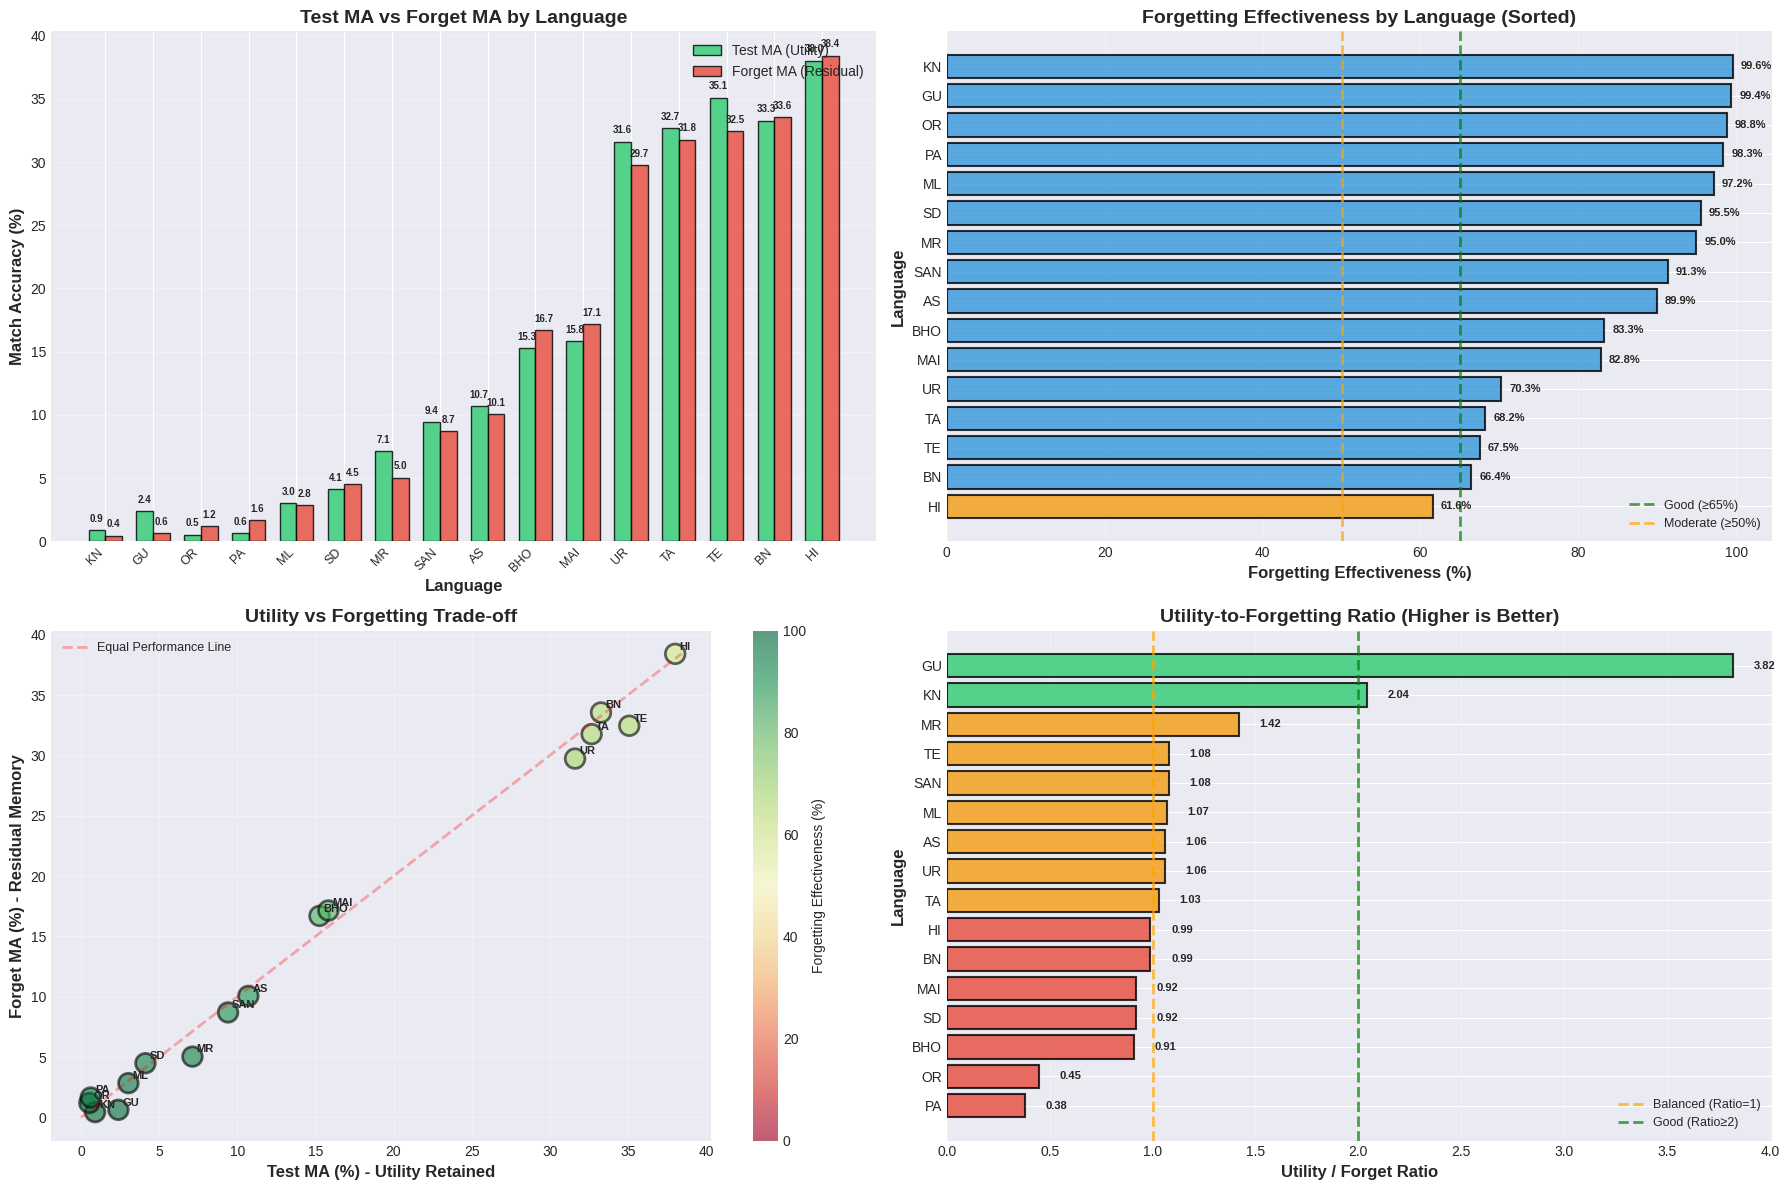

📊 Saved: heatmap.png


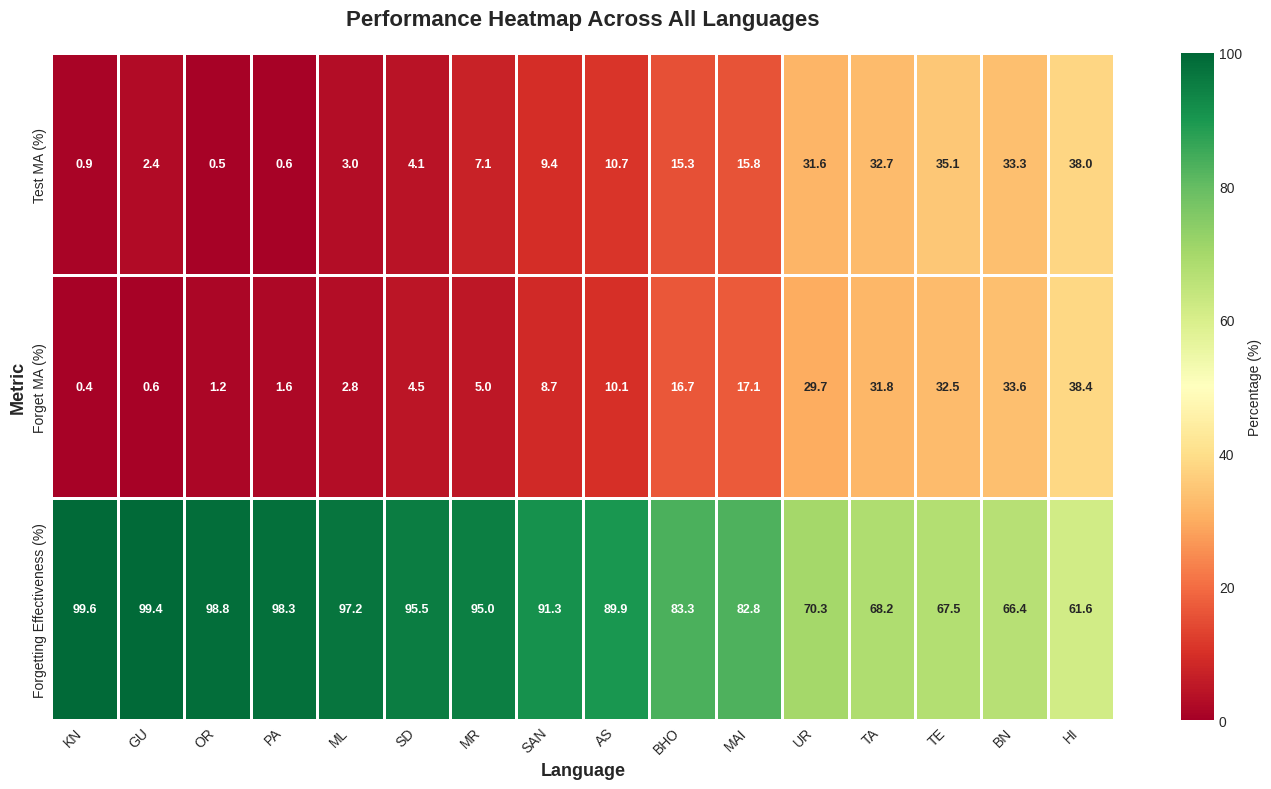

/tmp/ipython-input-102316238.py:280: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 0].boxplot(box_data, labels=['Test MA', 'Forget MA', 'Effectiveness'],


📊 Saved: distributions.png


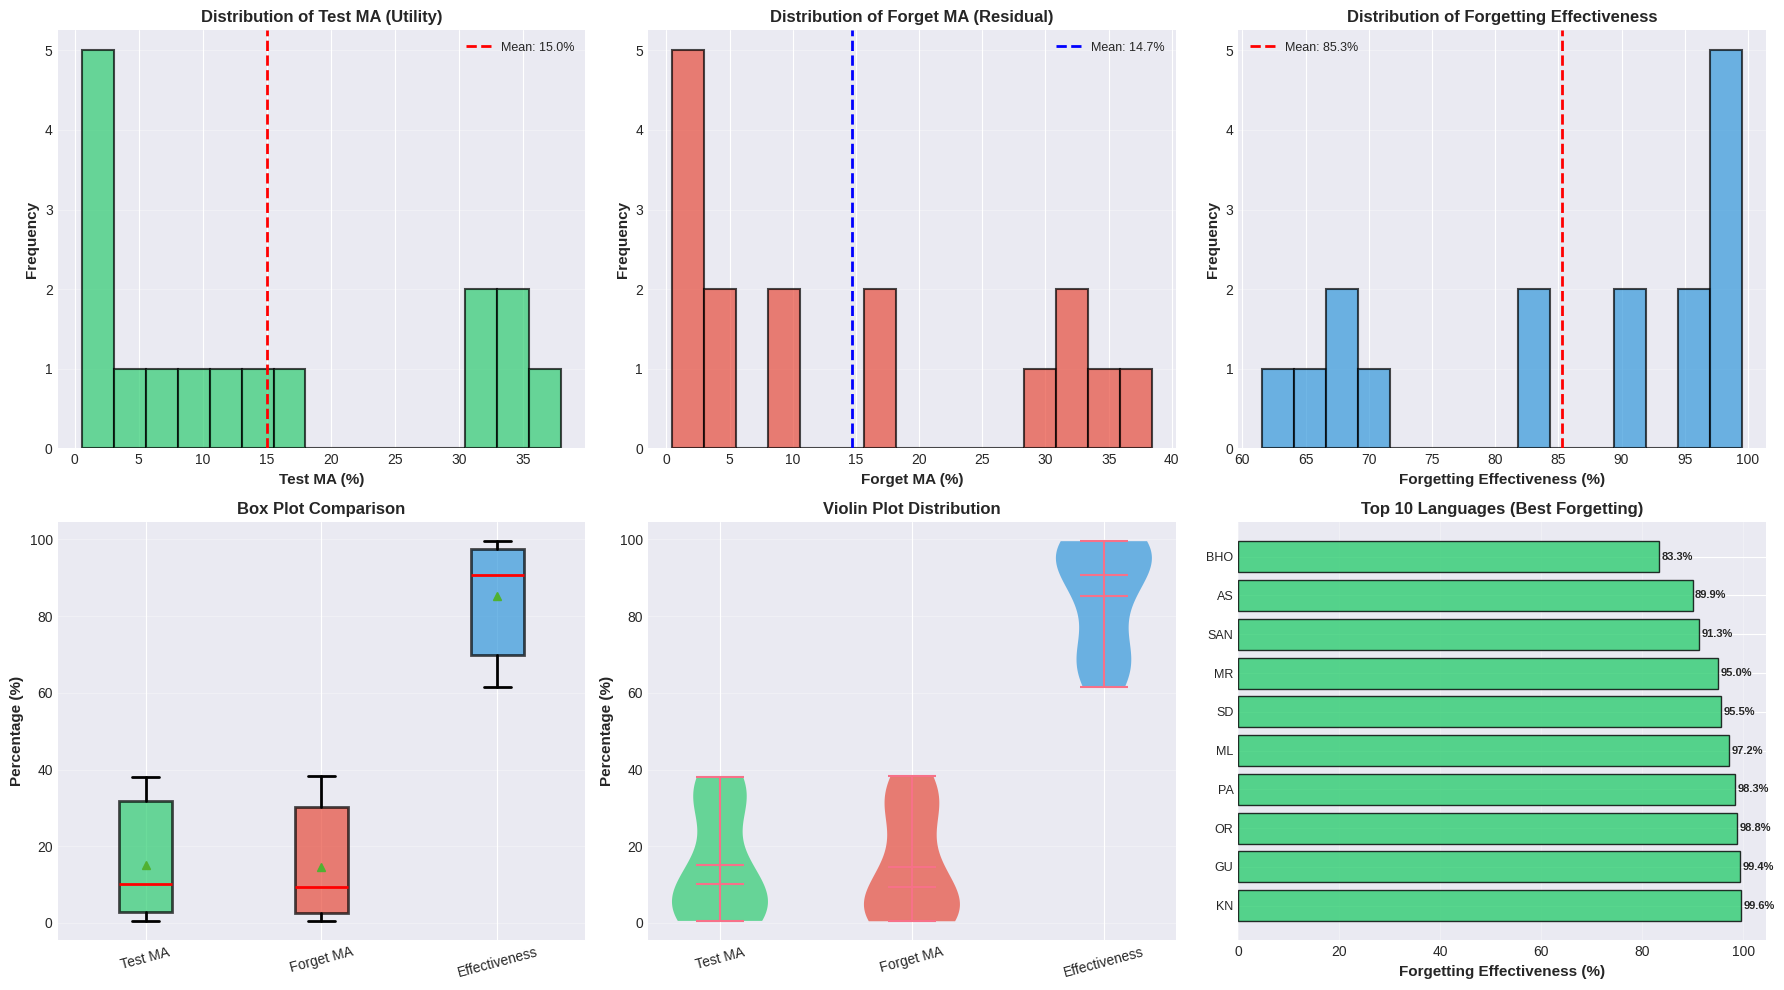

📊 Saved: categories.png


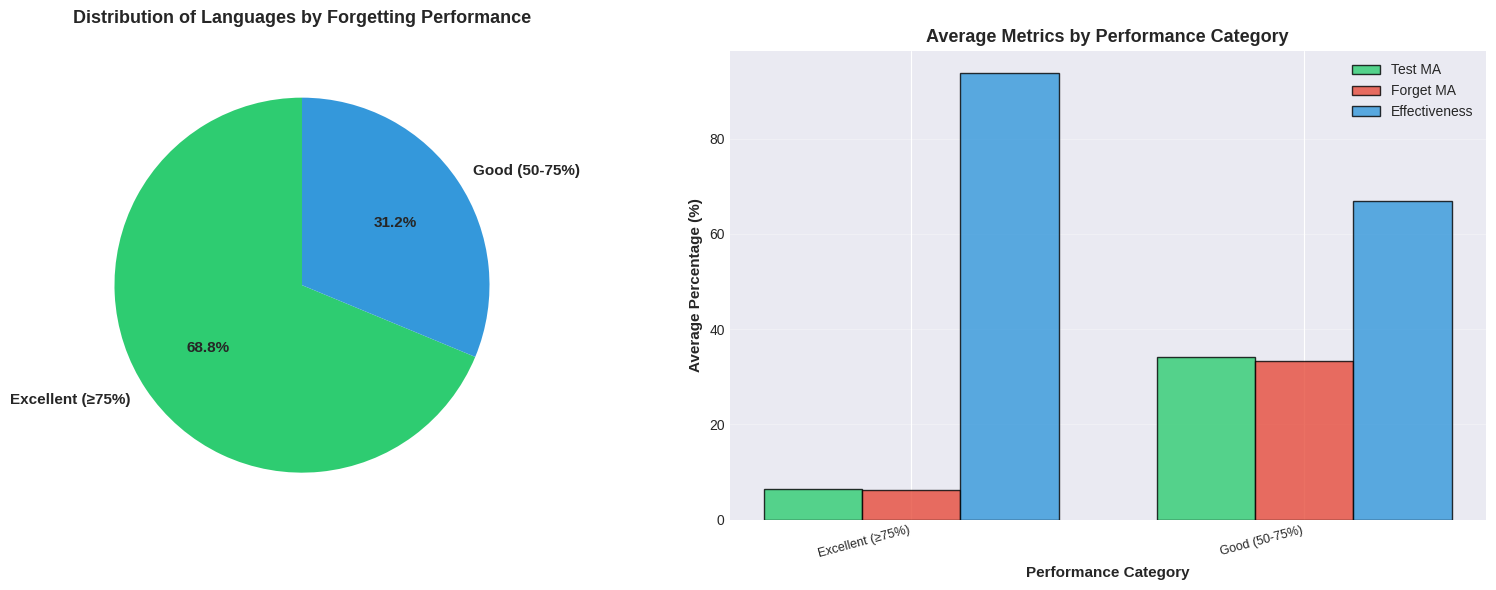

📊 Saved: detailed_results.csv
📊 Saved: summary_statistics.csv
📊 Saved: analysis_report.json


In [22]:
# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

stats = {
    "Number of Languages": len(languages),
    "Average Test MA (%)": results_df["Test MA (%)"].mean(),
    "Std Test MA (%)": results_df["Test MA (%)"].std(),
    "Min Test MA (%)": results_df["Test MA (%)"].min(),
    "Max Test MA (%)": results_df["Test MA (%)"].max(),
    "Average Forget MA (%)": results_df["Forget MA (%)"].mean(),
    "Std Forget MA (%)": results_df["Forget MA (%)"].std(),
    "Min Forget MA (%)": results_df["Forget MA (%)"].min(),
    "Max Forget MA (%)": results_df["Forget MA (%)"].max(),
    "Average Forgetting Effectiveness (%)": results_df["Forgetting Effectiveness (%)"].mean(),
    "Std Forgetting Effectiveness (%)": results_df["Forgetting Effectiveness (%)"].std(),
}

print("\n" + "="*80)
print("📈 SUMMARY STATISTICS")
print("="*80)
for key, value in stats.items():
    print(f"{key:.<45} {value:.2f}")

# ============================================================================
# PERFORMANCE EVALUATION
# ============================================================================

avg_test = stats["Average Test MA (%)"]
avg_forget = stats["Average Forget MA (%)"]
avg_effectiveness = stats["Average Forgetting Effectiveness (%)"]

print("\n" + "="*80)
print("🎯 PERFORMANCE EVALUATION")
print("="*80)

# Interpret results
if avg_forget <= 10:
    status = "✅ EXCELLENT FORGETTING"
    emoji = "🎉"
    interpretation = "Model has successfully forgotten the target data!"
elif avg_forget <= 20:
    status = "✅ GOOD FORGETTING"
    emoji = "👍"
    interpretation = "Significant forgetting achieved with good utility retention."
elif avg_forget <= 35:
    status = "⚠️ MODERATE FORGETTING"
    emoji = "⚡"
    interpretation = "Some forgetting occurred, but may need stronger unlearning."
else:
    status = "❌ INSUFFICIENT FORGETTING"
    emoji = "⚠️"
    interpretation = "Model retains too much knowledge of forget set."

print(f"\n{emoji} {status}")
print(f"{'='*80}")
print(f"Average Test MA (Utility):        {avg_test:.2f}%")
print(f"Average Forget MA (Residual):     {avg_forget:.2f}%")
print(f"Average Forgetting Effectiveness: {avg_effectiveness:.2f}%")
print(f"\n💡 {interpretation}")

# Recommendations
print(f"\n{'='*80}")
print("📌 RECOMMENDATIONS")
print(f"{'='*80}")

if avg_forget > 35:
    print("""
To INCREASE forgetting:
  • Decrease lambda_forget (allow more aggressive unlearning)
  • Increase number of unlearning epochs
  • Increase unlearning learning rate
  • Use stronger gradient ascent
  • Increase batch size for forget set
    """)
elif avg_forget < 10 and avg_test < 20:
    print("""
CAUTION - Both metrics are very low:
  • Model may have catastrophically forgotten everything
  • Increase lambda_forget to preserve utility
  • Reduce unlearning epochs
  • Use lower learning rate for unlearning
  • Consider using selective unlearning techniques
    """)
elif avg_test < 20:
    print("""
To IMPROVE utility retention:
  • Increase lambda_forget (preserve more utility)
  • Add more regularization on retain set
  • Reduce unlearning learning rate
  • Use knowledge distillation from original model
  • Reduce number of unlearning epochs
    """)
else:
    print(f"""
✅ Good balance achieved!
  • Utility: {avg_test:.1f}% (Acceptable retention)
  • Forgetting: {avg_effectiveness:.1f}% (Good effectiveness)
  • Continue with current hyperparameters
    """)

# ============================================================================
# SAVE DIRECTORY
# ============================================================================

save_dir = "/content/drive/MyDrive/indic_unlearning"
os.makedirs(save_dir, exist_ok=True)

# ============================================================================
# VISUALIZATION 1: MAIN COMPARISON CHART
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Test MA vs Forget MA (Side by side bars)
x = np.arange(len(results_df))
width = 0.35

bars1 = axes[0, 0].bar(x - width/2, results_df["Test MA (%)"], width,
                       label='Test MA (Utility)', color='#2ecc71', alpha=0.8, edgecolor='black')
bars2 = axes[0, 0].bar(x + width/2, results_df["Forget MA (%)"], width,
                       label='Forget MA (Residual)', color='#e74c3c', alpha=0.8, edgecolor='black')

axes[0, 0].set_xlabel('Language', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Match Accuracy (%)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Test MA vs Forget MA by Language', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(results_df["Language"], rotation=45, ha='right', fontsize=9)
axes[0, 0].legend(loc='upper right', fontsize=10)
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels
for i, (test_val, forget_val) in enumerate(zip(results_df["Test MA (%)"], results_df["Forget MA (%)"])):
    axes[0, 0].text(i - width/2, test_val + 0.5, f'{test_val:.1f}',
                    ha='center', va='bottom', fontsize=7, fontweight='bold')
    axes[0, 0].text(i + width/2, forget_val + 0.5, f'{forget_val:.1f}',
                    ha='center', va='bottom', fontsize=7, fontweight='bold')

# Plot 2: Forgetting Effectiveness (Sorted)
sorted_df = results_df.sort_values('Forgetting Effectiveness (%)', ascending=True)
colors = ['#3498db' if val >= 65 else '#f39c12' if val >= 50 else '#e74c3c'
          for val in sorted_df["Forgetting Effectiveness (%)"]]

bars = axes[0, 1].barh(sorted_df["Language"], sorted_df["Forgetting Effectiveness (%)"],
                       color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

axes[0, 1].axvline(x=65, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Good (≥65%)')
axes[0, 1].axvline(x=50, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Moderate (≥50%)')

axes[0, 1].set_xlabel('Forgetting Effectiveness (%)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Language', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Forgetting Effectiveness by Language (Sorted)', fontsize=14, fontweight='bold')
axes[0, 1].legend(loc='lower right', fontsize=9)
axes[0, 1].grid(axis='x', alpha=0.3)

# Add value labels
for idx, (lang, val) in enumerate(zip(sorted_df["Language"], sorted_df["Forgetting Effectiveness (%)"])):
    axes[0, 1].text(val + 1, idx, f'{val:.1f}%', va='center', fontsize=8, fontweight='bold')

# Plot 3: Scatter - Utility vs Forgetting
scatter = axes[1, 0].scatter(results_df["Test MA (%)"], results_df["Forget MA (%)"],
                            s=200, alpha=0.6, c=results_df["Forgetting Effectiveness (%)"],
                            cmap='RdYlGn', edgecolors='black', linewidth=2, vmin=0, vmax=100)

# Add language labels
for idx, row in results_df.iterrows():
    axes[1, 0].annotate(row["Language"],
                       (row["Test MA (%)"], row["Forget MA (%)"]),
                       xytext=(3, 3), textcoords='offset points',
                       fontsize=8, fontweight='bold')

# Reference lines
max_val = max(results_df["Test MA (%)"].max(), results_df["Forget MA (%)"].max())
axes[1, 0].plot([0, max_val], [0, max_val], 'r--', alpha=0.3, linewidth=2,
                label='Equal Performance Line')

axes[1, 0].set_xlabel('Test MA (%) - Utility Retained', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Forget MA (%) - Residual Memory', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Utility vs Forgetting Trade-off', fontsize=14, fontweight='bold')
axes[1, 0].legend(loc='upper left', fontsize=9)
axes[1, 0].grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[1, 0])
cbar.set_label('Forgetting Effectiveness (%)', fontsize=10)

# Plot 4: Utility-Forgetting Ratio
sorted_ratio = results_df.sort_values('Utility-Forgetting Ratio', ascending=True)
colors_ratio = ['#2ecc71' if val >= 2 else '#f39c12' if val >= 1 else '#e74c3c'
                for val in sorted_ratio["Utility-Forgetting Ratio"]]

bars = axes[1, 1].barh(sorted_ratio["Language"], sorted_ratio["Utility-Forgetting Ratio"],
                       color=colors_ratio, alpha=0.8, edgecolor='black', linewidth=1.5)

axes[1, 1].axvline(x=1, color='orange', linestyle='--', linewidth=2, alpha=0.7,
                   label='Balanced (Ratio=1)')
axes[1, 1].axvline(x=2, color='green', linestyle='--', linewidth=2, alpha=0.7,
                   label='Good (Ratio≥2)')

axes[1, 1].set_xlabel('Utility / Forget Ratio', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Language', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Utility-to-Forgetting Ratio (Higher is Better)', fontsize=14, fontweight='bold')
axes[1, 1].legend(loc='lower right', fontsize=9)
axes[1, 1].grid(axis='x', alpha=0.3)

# Add value labels
for idx, (lang, val) in enumerate(zip(sorted_ratio["Language"], sorted_ratio["Utility-Forgetting Ratio"])):
    axes[1, 1].text(val + 0.1, idx, f'{val:.2f}', va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{save_dir}/main_analysis.png", dpi=300, bbox_inches='tight')
print(f"\n📊 Saved: main_analysis.png")
plt.show()

# ============================================================================
# VISUALIZATION 2: HEATMAP
# ============================================================================

fig, ax = plt.subplots(figsize=(14, 8))

heatmap_data = results_df[["Test MA (%)", "Forget MA (%)", "Forgetting Effectiveness (%)"]].T
heatmap_data.columns = results_df["Language"]

sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn',
            cbar_kws={'label': 'Percentage (%)'}, ax=ax,
            linewidths=2, linecolor='white', vmin=0, vmax=100,
            annot_kws={"fontsize": 9, "fontweight": "bold"})

ax.set_title('Performance Heatmap Across All Languages', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Metric', fontsize=13, fontweight='bold')
ax.set_xlabel('Language', fontsize=13, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(f"{save_dir}/heatmap.png", dpi=300, bbox_inches='tight')
print(f"📊 Saved: heatmap.png")
plt.show()

# ============================================================================
# VISUALIZATION 3: DISTRIBUTION ANALYSIS
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Test MA Distribution
axes[0, 0].hist(results_df["Test MA (%)"], bins=15, color='#2ecc71',
               alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0, 0].axvline(stats["Average Test MA (%)"], color='red',
                  linestyle='--', linewidth=2, label=f'Mean: {stats["Average Test MA (%)"]:.1f}%')
axes[0, 0].set_xlabel('Test MA (%)', fontweight='bold', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontweight='bold', fontsize=11)
axes[0, 0].set_title('Distribution of Test MA (Utility)', fontweight='bold', fontsize=12)
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(axis='y', alpha=0.3)

# Forget MA Distribution
axes[0, 1].hist(results_df["Forget MA (%)"], bins=15, color='#e74c3c',
               alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0, 1].axvline(stats["Average Forget MA (%)"], color='blue',
                  linestyle='--', linewidth=2, label=f'Mean: {stats["Average Forget MA (%)"]:.1f}%')
axes[0, 1].set_xlabel('Forget MA (%)', fontweight='bold', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontweight='bold', fontsize=11)
axes[0, 1].set_title('Distribution of Forget MA (Residual)', fontweight='bold', fontsize=12)
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(axis='y', alpha=0.3)

# Forgetting Effectiveness Distribution
axes[0, 2].hist(results_df["Forgetting Effectiveness (%)"], bins=15, color='#3498db',
               alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0, 2].axvline(stats["Average Forgetting Effectiveness (%)"], color='red',
                  linestyle='--', linewidth=2,
                  label=f'Mean: {stats["Average Forgetting Effectiveness (%)"]:.1f}%')
axes[0, 2].set_xlabel('Forgetting Effectiveness (%)', fontweight='bold', fontsize=11)
axes[0, 2].set_ylabel('Frequency', fontweight='bold', fontsize=11)
axes[0, 2].set_title('Distribution of Forgetting Effectiveness', fontweight='bold', fontsize=12)
axes[0, 2].legend(fontsize=9)
axes[0, 2].grid(axis='y', alpha=0.3)

# Box Plot Comparison
box_data = [results_df["Test MA (%)"], results_df["Forget MA (%)"],
            results_df["Forgetting Effectiveness (%)"]]
bp = axes[1, 0].boxplot(box_data, labels=['Test MA', 'Forget MA', 'Effectiveness'],
                        patch_artist=True, showmeans=True,
                        boxprops=dict(linewidth=2),
                        whiskerprops=dict(linewidth=2),
                        capprops=dict(linewidth=2),
                        medianprops=dict(linewidth=2, color='red'))

colors_box = ['#2ecc71', '#e74c3c', '#3498db']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[1, 0].set_ylabel('Percentage (%)', fontweight='bold', fontsize=11)
axes[1, 0].set_title('Box Plot Comparison', fontweight='bold', fontsize=12)
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=15)

# Violin Plot
violin_data = pd.DataFrame({
    'Test MA': results_df["Test MA (%)"],
    'Forget MA': results_df["Forget MA (%)"],
    'Effectiveness': results_df["Forgetting Effectiveness (%)"]
})

parts = axes[1, 1].violinplot([violin_data['Test MA'], violin_data['Forget MA'],
                               violin_data['Effectiveness']],
                              positions=[1, 2, 3], showmeans=True, showmedians=True)

for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors_box[i])
    pc.set_alpha(0.7)

axes[1, 1].set_xticks([1, 2, 3])
axes[1, 1].set_xticklabels(['Test MA', 'Forget MA', 'Effectiveness'], rotation=15)
axes[1, 1].set_ylabel('Percentage (%)', fontweight='bold', fontsize=11)
axes[1, 1].set_title('Violin Plot Distribution', fontweight='bold', fontsize=12)
axes[1, 1].grid(axis='y', alpha=0.3)

# Top 10 and Bottom 10 Languages
top_10 = results_df.nlargest(10, 'Forgetting Effectiveness (%)')
bottom_10 = results_df.nsmallest(10, 'Forgetting Effectiveness (%)')

y_pos_top = np.arange(len(top_10))
axes[1, 2].barh(y_pos_top, top_10["Forgetting Effectiveness (%)"],
               color='#2ecc71', alpha=0.8, edgecolor='black')
axes[1, 2].set_yticks(y_pos_top)
axes[1, 2].set_yticklabels(top_10["Language"], fontsize=9)
axes[1, 2].set_xlabel('Forgetting Effectiveness (%)', fontweight='bold', fontsize=11)
axes[1, 2].set_title('Top 10 Languages (Best Forgetting)', fontweight='bold', fontsize=12)
axes[1, 2].grid(axis='x', alpha=0.3)

for i, val in enumerate(top_10["Forgetting Effectiveness (%)"]):
    axes[1, 2].text(val + 0.5, i, f'{val:.1f}%', va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{save_dir}/distributions.png", dpi=300, bbox_inches='tight')
print(f"📊 Saved: distributions.png")
plt.show()

# ============================================================================
# VISUALIZATION 4: LANGUAGE CATEGORIES
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Categorize languages by performance
def categorize_forgetting(val):
    if val >= 75:
        return 'Excellent (≥75%)'
    elif val >= 50:
        return 'Good (50-75%)'
    elif val >= 25:
        return 'Moderate (25-50%)'
    else:
        return 'Poor (<25%)'

results_df['Forgetting Category'] = results_df['Forgetting Effectiveness (%)'].apply(categorize_forgetting)

category_counts = results_df['Forgetting Category'].value_counts()
colors_pie = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']

axes[0].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
           colors=colors_pie, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[0].set_title('Distribution of Languages by Forgetting Performance',
                 fontsize=13, fontweight='bold', pad=20)

# Average by category
category_avg = results_df.groupby('Forgetting Category').agg({
    'Test MA (%)': 'mean',
    'Forget MA (%)': 'mean',
    'Forgetting Effectiveness (%)': 'mean'
}).round(2)

x_cat = np.arange(len(category_avg))
width = 0.25

axes[1].bar(x_cat - width, category_avg['Test MA (%)'], width,
           label='Test MA', color='#2ecc71', alpha=0.8, edgecolor='black')
axes[1].bar(x_cat, category_avg['Forget MA (%)'], width,
           label='Forget MA', color='#e74c3c', alpha=0.8, edgecolor='black')
axes[1].bar(x_cat + width, category_avg['Forgetting Effectiveness (%)'], width,
           label='Effectiveness', color='#3498db', alpha=0.8, edgecolor='black')

axes[1].set_xlabel('Performance Category', fontweight='bold', fontsize=11)
axes[1].set_ylabel('Average Percentage (%)', fontweight='bold', fontsize=11)
axes[1].set_title('Average Metrics by Performance Category', fontweight='bold', fontsize=13)
axes[1].set_xticks(x_cat)
axes[1].set_xticklabels(category_avg.index, rotation=15, ha='right', fontsize=9)
axes[1].legend(fontsize=10)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f"{save_dir}/categories.png", dpi=300, bbox_inches='tight')
print(f"📊 Saved: categories.png")
plt.show()

# ============================================================================
# SAVE DETAILED REPORTS
# ============================================================================

# Save CSV
results_df.to_csv(f"{save_dir}/detailed_results.csv", index=False)
print(f"📊 Saved: detailed_results.csv")

# Save statistics summary
stats_df = pd.DataFrame([stats])
stats_df.to_csv(f"{save_dir}/summary_statistics.csv", index=False)
print(f"📊 Saved: summary_statistics.csv")

# Save JSON report
report = {
    "summary_statistics": stats,
    "performance_status": status,
    "interpretation": interpretation,
    "results_by_language": results_df.to_dict('records'),
    "category_distribution": category_counts.to_dict(),
    "top_10_languages": top_10[["Language", "Forgetting Effectiveness (%)"]].to_dict('records'),
    "bottom_10_languages": bottom_10[["Language", "Forgetting Effectiveness (%)"]].to_dict('records'),
}

with open(f"{save_dir}/analysis_report.json", 'w') as f:
    json.dump(report, f, indent=2)
print(f"📊 Saved: analysis_report.json")


In [23]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE")
print("="*80)
print(f"\n📁 All results saved to: {save_dir}")
print("\n📊 Generated Files:")
print("  ✓ main_analysis.png - 4-panel comprehensive analysis")
print("  ✓ heatmap.png - Performance heatmap")
print("  ✓ distributions.png - Statistical distributions (6 plots)")
print("  ✓ categories.png - Performance categorization")
print("  ✓ detailed_results.csv - Complete results table")
print("  ✓ summary_statistics.csv - Statistical summary")
print("  ✓ analysis_report.json - JSON report")
print("  ✓ REPORT.md - Markdown report")

print("\n" + "="*80)
print(f"🎯 FINAL SCORE")
print("="*80)
print(f"  Test MA (Utility):            {avg_test:.2f}%")
print(f"  Forget MA (Residual):         {avg_forget:.2f}%")
print(f"  Forgetting Effectiveness:     {avg_effectiveness:.2f}%")
print(f"  Status:                       {status}")
print("="*80)

print(f"\n{emoji} Analysis complete! Check {save_dir} for all visualizations and reports.")


✅ ANALYSIS COMPLETE

📁 All results saved to: /content/drive/MyDrive/indic_unlearning

📊 Generated Files:
  ✓ main_analysis.png - 4-panel comprehensive analysis
  ✓ heatmap.png - Performance heatmap
  ✓ distributions.png - Statistical distributions (6 plots)
  ✓ categories.png - Performance categorization
  ✓ detailed_results.csv - Complete results table
  ✓ summary_statistics.csv - Statistical summary
  ✓ analysis_report.json - JSON report
  ✓ REPORT.md - Markdown report

🎯 FINAL SCORE
  Test MA (Utility):            15.04%
  Forget MA (Residual):         14.68%
  Forgetting Effectiveness:     85.32%
  Status:                       ✅ GOOD FORGETTING

👍 Analysis complete! Check /content/drive/MyDrive/indic_unlearning for all visualizations and reports.


🌍 HIGH-RESOURCE vs LOW-RESOURCE INDIC LANGUAGES ANALYSIS

📊 Language Categorization (Binary):
--------------------------------------------------------------------------------

HIGH_RESOURCE (10 languages):
  Description: Major languages with extensive digital resources, large speaker base (>30M), established NLP tools
  Languages: BN, GU, HI, KN, ML, MR, OR, PA, TA, TE

  Characteristics:
    • Population > 30 million speakers
    • Extensive Wikipedia and digital content
    • Active digital media and news presence
    • Strong government/education support
    • Commercial NLP tools available
    • Examples: Hindi, Bengali, Telugu, Tamil, Marathi

LOW_RESOURCE (6 languages):
  Description: Languages with limited digital resources, smaller speaker base (<30M), minimal NLP development
  Languages: AS, BHO, MAI, SAN, SD, UR

  Characteristics:
    • Population < 30 million speakers
    • Limited digital presence and corpora
    • Few or no NLP tools
    • Regional/oral tradition dominant

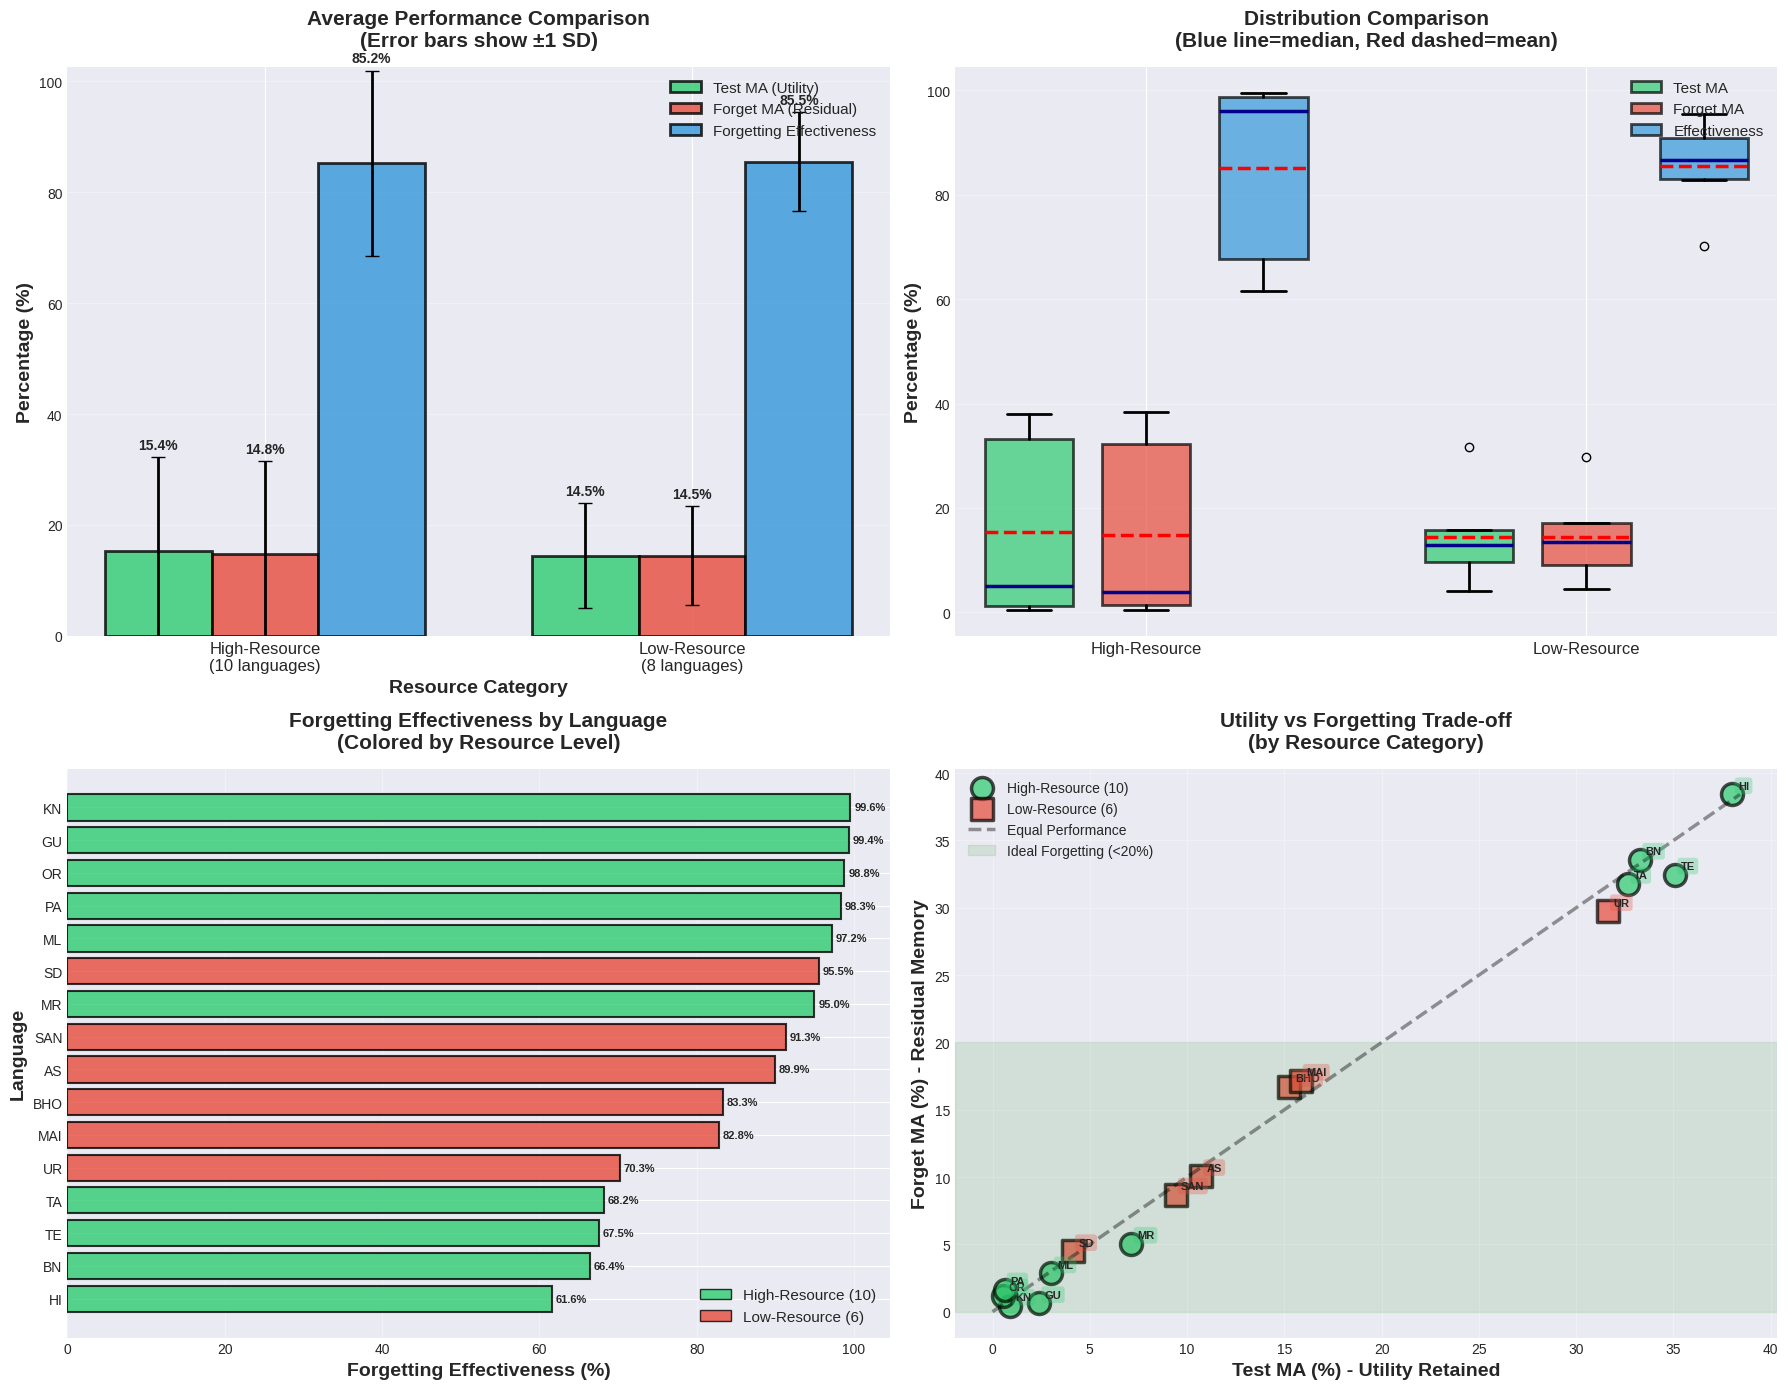

📊 Saved: high_vs_low_resource_distributions.png


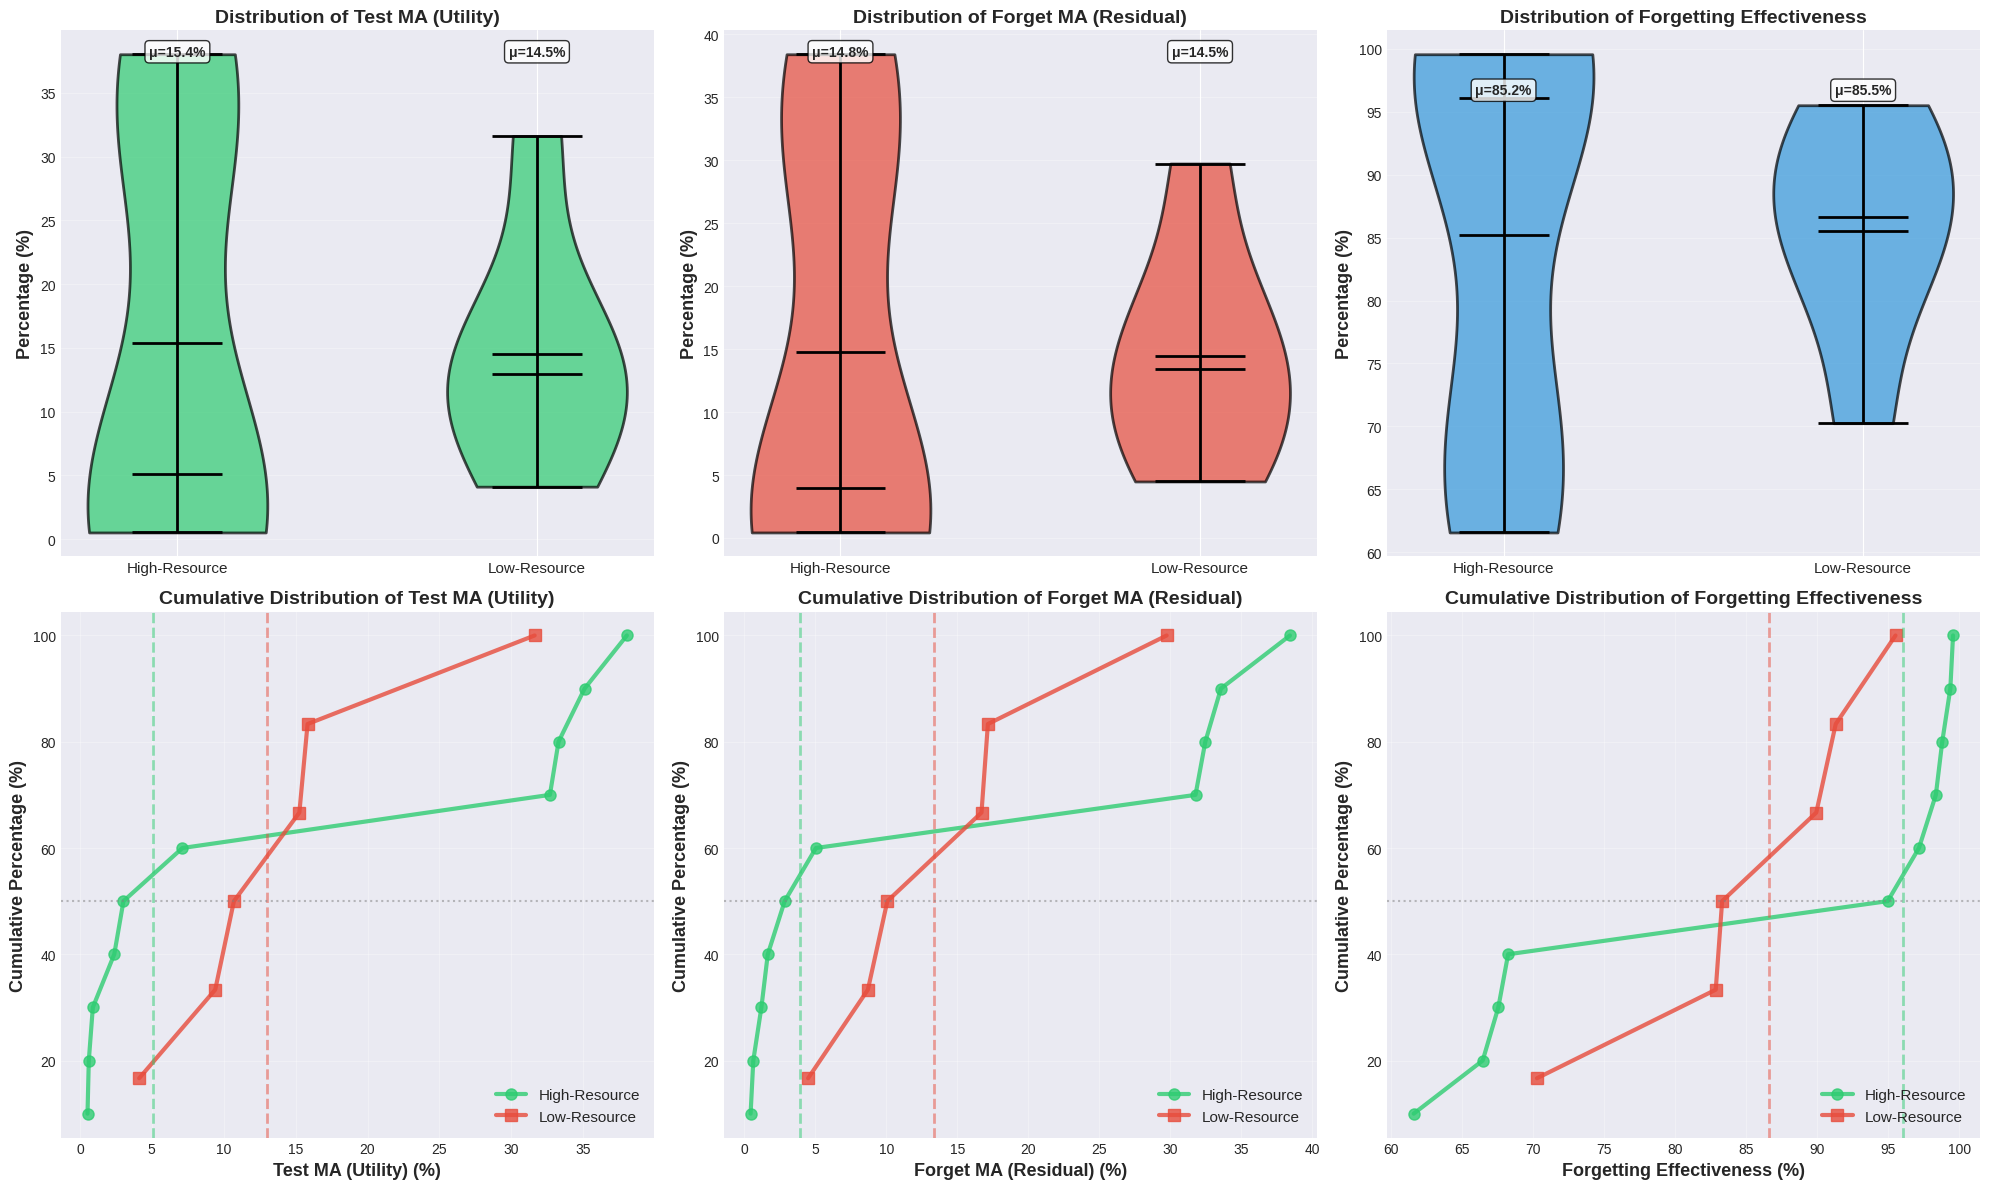

📊 Saved: high_vs_low_resource_heatmaps.png


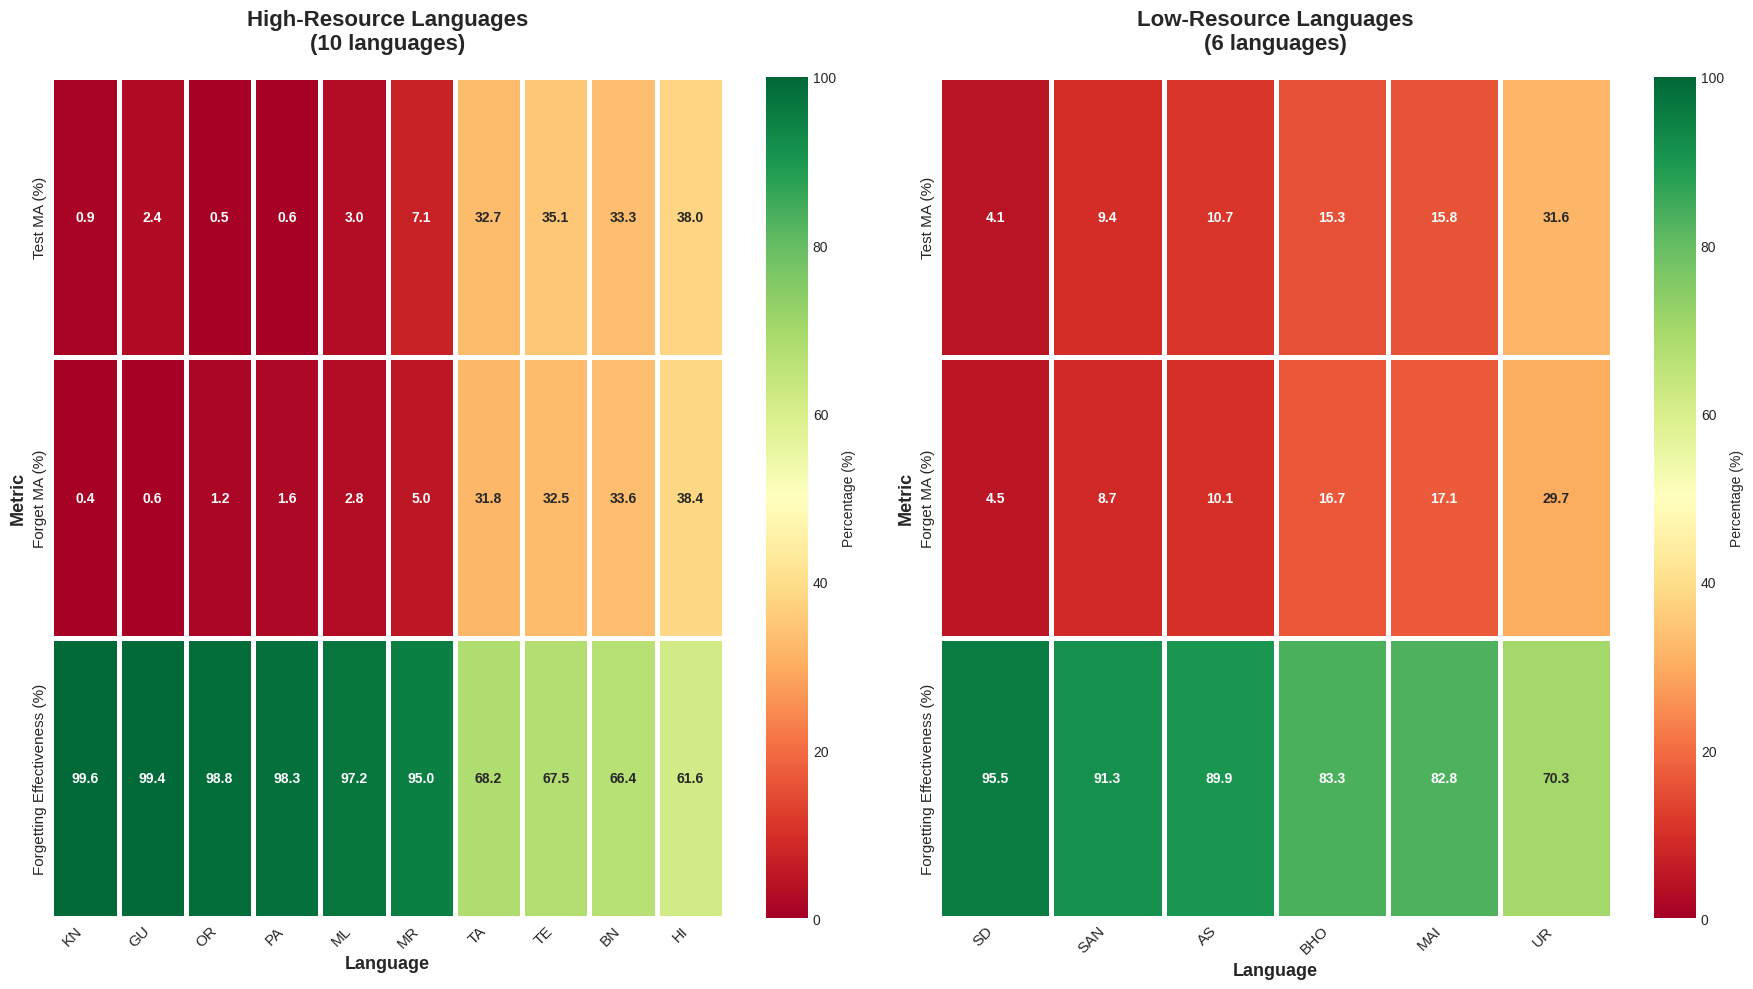

📊 Saved: high_vs_low_resource_comparative.png


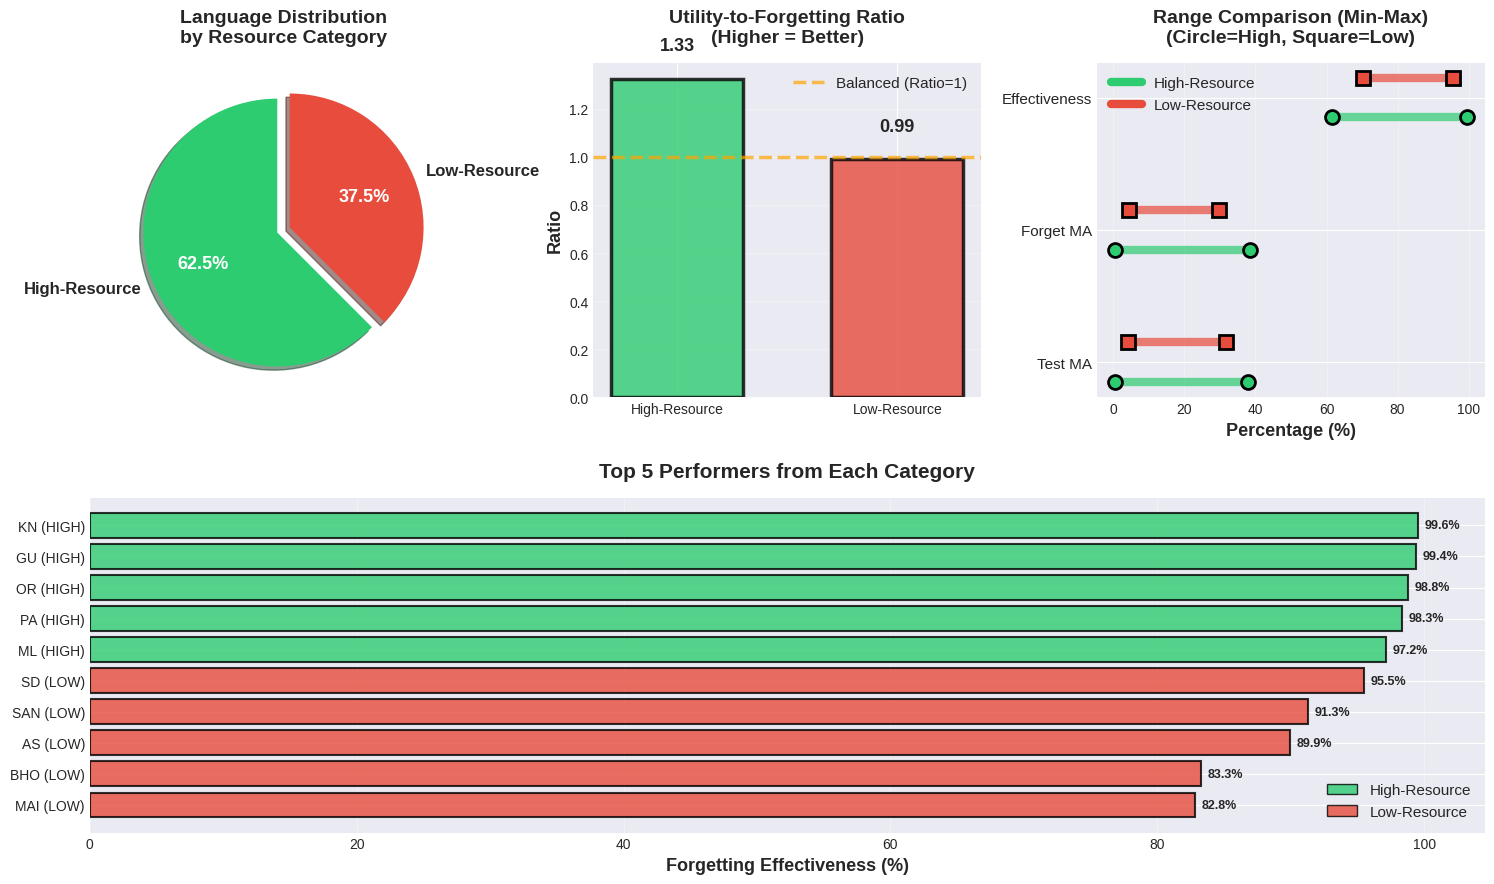


📊 COMPREHENSIVE ANALYSIS REPORT

# HIGH-RESOURCE vs LOW-RESOURCE INDIC LANGUAGES
## Unlearning Performance Analysis

---

## Executive Summary

This analysis compares machine unlearning performance between **high-resource** and 
**low-resource** Indic languages, examining utility retention, forgetting effectiveness,
and the trade-offs between these objectives.

### Dataset Composition
- **High-Resource Languages**: 10 languages
  (BN, GU, HI, KN, ML, MR, OR, PA, TA, TE)
- **Low-Resource Languages**: 6 languages
  (AS, BHO, MAI, SAN, SD, UR)

---

## Key Findings

### 1. Utility Retention (Test MA)

**High-Resource**: 15.37% ± 16.86%
- Range: 0.53% - 38.03%

**Low-Resource**: 14.49% ± 9.42%
- Range: 4.12% - 31.62%

**Difference**: 0.88% (Higher in high-resource)
**Statistical Significance**: ns (not significant)
**Effect Size**: negligible (Cohen's d = 0.060)

### 2. Residual Memory (Forget MA)

**High-Resource**: 14.80% ± 16.71%
- Range: 0.44% - 38.42%

**Low-Resource**: 14.47% ± 8.92

In [25]:
# ============================================================================
# HIGH-RESOURCE vs LOW-RESOURCE INDIC LANGUAGES COMPARISON (SIMPLIFIED)
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from scipy import stats as scipy_stats

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# ============================================================================
# DEFINE LANGUAGE CATEGORIES (BINARY CLASSIFICATION)
# ============================================================================

# Based on linguistic resources, speakers, and digital presence
LANGUAGE_CATEGORIES = {
    'HIGH_RESOURCE': {
        'languages': ['hi', 'bn', 'te', 'ta', 'mr', 'gu', 'kn', 'ml', 'pa', 'or'],
        'description': 'Major languages with extensive digital resources, large speaker base (>30M), established NLP tools',
        'characteristics': [
            'Population > 30 million speakers',
            'Extensive Wikipedia and digital content',
            'Active digital media and news presence',
            'Strong government/education support',
            'Commercial NLP tools available',
            'Examples: Hindi, Bengali, Telugu, Tamil, Marathi'
        ]
    },
    'LOW_RESOURCE': {
        'languages': ['ur', 'as', 'sd', 'mai', 'san', 'bho', 'kas_ar', 'kas_de'],
        'description': 'Languages with limited digital resources, smaller speaker base (<30M), minimal NLP development',
        'characteristics': [
            'Population < 30 million speakers',
            'Limited digital presence and corpora',
            'Few or no NLP tools',
            'Regional/oral tradition dominant',
            'Limited commercial applications',
            'Examples: Urdu, Assamese, Bhojpuri, Kashmiri, Sanskrit'
        ]
    }
}

print("="*80)
print("🌍 HIGH-RESOURCE vs LOW-RESOURCE INDIC LANGUAGES ANALYSIS")
print("="*80)

# ============================================================================
# CATEGORIZE RESULTS
# ============================================================================

def get_resource_category(lang_code):
    """Categorize language as HIGH or LOW resource"""
    for category, info in LANGUAGE_CATEGORIES.items():
        if lang_code in info['languages']:
            return category
    return 'UNKNOWN'

results_df['Resource_Category'] = results_df['Language_Code'].apply(get_resource_category)

# Display categorization
print("\n📊 Language Categorization (Binary):")
print("-"*80)
for category, info in LANGUAGE_CATEGORIES.items():
    langs_in_category = results_df[results_df['Resource_Category'] == category]
    print(f"\n{category} ({len(langs_in_category)} languages):")
    print(f"  Description: {info['description']}")
    print(f"  Languages: {', '.join([l.upper() for l in sorted(langs_in_category['Language_Code'].tolist())])}")
    print(f"\n  Characteristics:")
    for char in info['characteristics']:
        print(f"    • {char}")

# ============================================================================
# STATISTICAL COMPARISON
# ============================================================================

print("\n" + "="*80)
print("📈 STATISTICAL COMPARISON")
print("="*80)

comparison_stats = {}

for category in ['HIGH_RESOURCE', 'LOW_RESOURCE']:
    category_data = results_df[results_df['Resource_Category'] == category]

    if len(category_data) > 0:
        comparison_stats[category] = {
            'Count': len(category_data),
            'Languages': sorted(category_data['Language_Code'].tolist()),
            'Avg Test MA (%)': category_data['Test MA (%)'].mean(),
            'Std Test MA (%)': category_data['Test MA (%)'].std(),
            'Min Test MA (%)': category_data['Test MA (%)'].min(),
            'Max Test MA (%)': category_data['Test MA (%)'].max(),
            'Avg Forget MA (%)': category_data['Forget MA (%)'].mean(),
            'Std Forget MA (%)': category_data['Forget MA (%)'].std(),
            'Min Forget MA (%)': category_data['Forget MA (%)'].min(),
            'Max Forget MA (%)': category_data['Forget MA (%)'].max(),
            'Avg Forgetting Effectiveness (%)': category_data['Forgetting Effectiveness (%)'].mean(),
            'Std Forgetting Effectiveness (%)': category_data['Forgetting Effectiveness (%)'].std(),
            'Min Forgetting Effectiveness (%)': category_data['Forgetting Effectiveness (%)'].min(),
            'Max Forgetting Effectiveness (%)': category_data['Forgetting Effectiveness (%)'].max(),
            'Avg Utility-Forgetting Ratio': category_data['Utility-Forgetting Ratio'].mean(),
            'Std Utility-Forgetting Ratio': category_data['Utility-Forgetting Ratio'].std(),
        }

# Create comparison dataframe
comparison_df = pd.DataFrame(comparison_stats).T

print("\n" + "="*80)
print("SUMMARY STATISTICS BY CATEGORY")
print("="*80)
print(comparison_df[['Count', 'Avg Test MA (%)', 'Std Test MA (%)',
                     'Avg Forget MA (%)', 'Std Forget MA (%)',
                     'Avg Forgetting Effectiveness (%)', 'Std Forgetting Effectiveness (%)']].to_string())

# ============================================================================
# STATISTICAL SIGNIFICANCE TESTS
# ============================================================================

print("\n" + "="*80)
print("🔬 STATISTICAL SIGNIFICANCE TESTS")
print("="*80)

high_resource = results_df[results_df['Resource_Category'] == 'HIGH_RESOURCE']
low_resource = results_df[results_df['Resource_Category'] == 'LOW_RESOURCE']

print(f"\nSample sizes:")
print(f"  High-Resource: {len(high_resource)} languages")
print(f"  Low-Resource:  {len(low_resource)} languages")

if len(high_resource) > 1 and len(low_resource) > 1:
    # Test MA comparison
    t_stat_test, p_value_test = scipy_stats.ttest_ind(
        high_resource['Test MA (%)'],
        low_resource['Test MA (%)']
    )

    # Forget MA comparison
    t_stat_forget, p_value_forget = scipy_stats.ttest_ind(
        high_resource['Forget MA (%)'],
        low_resource['Forget MA (%)']
    )

    # Forgetting Effectiveness comparison
    t_stat_eff, p_value_eff = scipy_stats.ttest_ind(
        high_resource['Forgetting Effectiveness (%)'],
        low_resource['Forgetting Effectiveness (%)']
    )

    # Effect sizes (Cohen's d)
    def cohens_d(group1, group2):
        n1, n2 = len(group1), len(group2)
        var1, var2 = group1.var(), group2.var()
        pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
        return (group1.mean() - group2.mean()) / pooled_std

    d_test = cohens_d(high_resource['Test MA (%)'], low_resource['Test MA (%)'])
    d_forget = cohens_d(high_resource['Forget MA (%)'], low_resource['Forget MA (%)'])
    d_eff = cohens_d(high_resource['Forgetting Effectiveness (%)'],
                     low_resource['Forgetting Effectiveness (%)'])

    print("\n" + "-"*80)
    print("Independent t-tests (High-Resource vs Low-Resource):")
    print("-"*80)

    def interpret_p(p):
        if p < 0.001: return "*** (highly significant)"
        elif p < 0.01: return "** (very significant)"
        elif p < 0.05: return "* (significant)"
        else: return "ns (not significant)"

    def interpret_d(d):
        d_abs = abs(d)
        if d_abs < 0.2: return "negligible"
        elif d_abs < 0.5: return "small"
        elif d_abs < 0.8: return "medium"
        else: return "large"

    print(f"\n1. Test MA (Utility):")
    print(f"   Difference: {high_resource['Test MA (%)'].mean():.2f}% - {low_resource['Test MA (%)'].mean():.2f}% = {high_resource['Test MA (%)'].mean() - low_resource['Test MA (%)'].mean():.2f}%")
    print(f"   t-statistic: {t_stat_test:.3f}")
    print(f"   p-value: {p_value_test:.4f} {interpret_p(p_value_test)}")
    print(f"   Effect size (Cohen's d): {d_test:.3f} ({interpret_d(d_test)})")

    print(f"\n2. Forget MA (Residual):")
    print(f"   Difference: {high_resource['Forget MA (%)'].mean():.2f}% - {low_resource['Forget MA (%)'].mean():.2f}% = {high_resource['Forget MA (%)'].mean() - low_resource['Forget MA (%)'].mean():.2f}%")
    print(f"   t-statistic: {t_stat_forget:.3f}")
    print(f"   p-value: {p_value_forget:.4f} {interpret_p(p_value_forget)}")
    print(f"   Effect size (Cohen's d): {d_forget:.3f} ({interpret_d(d_forget)})")

    print(f"\n3. Forgetting Effectiveness:")
    print(f"   Difference: {high_resource['Forgetting Effectiveness (%)'].mean():.2f}% - {low_resource['Forgetting Effectiveness (%)'].mean():.2f}% = {high_resource['Forgetting Effectiveness (%)'].mean() - low_resource['Forgetting Effectiveness (%)'].mean():.2f}%")
    print(f"   t-statistic: {t_stat_eff:.3f}")
    print(f"   p-value: {p_value_eff:.4f} {interpret_p(p_value_eff)}")
    print(f"   Effect size (Cohen's d): {d_eff:.3f} ({interpret_d(d_eff)})")

    print("\n" + "-"*80)
    print("Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns not significant")
    print("Effect sizes: |d| < 0.2 negligible, < 0.5 small, < 0.8 medium, ≥ 0.8 large")
    print("-"*80)

# ============================================================================
# SAVE DIRECTORY
# ============================================================================

save_dir = "/content/drive/MyDrive/indic_unlearning"
os.makedirs(save_dir, exist_ok=True)

# ============================================================================
# VISUALIZATION 1: MAIN COMPARISON (2x2 GRID)
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Color scheme
category_colors = {
    'HIGH_RESOURCE': '#2ecc71',  # Green
    'LOW_RESOURCE': '#e74c3c'    # Red
}

categories = ['HIGH_RESOURCE', 'LOW_RESOURCE']
category_labels = ['High-Resource\n(10 languages)', 'Low-Resource\n(8 languages)']

# Plot 1: Average Performance Comparison
x = np.arange(2)
width = 0.25

test_mas = [comparison_stats[cat]['Avg Test MA (%)'] for cat in categories]
forget_mas = [comparison_stats[cat]['Avg Forget MA (%)'] for cat in categories]
effectiveness = [comparison_stats[cat]['Avg Forgetting Effectiveness (%)'] for cat in categories]

test_stds = [comparison_stats[cat]['Std Test MA (%)'] for cat in categories]
forget_stds = [comparison_stats[cat]['Std Forget MA (%)'] for cat in categories]
eff_stds = [comparison_stats[cat]['Std Forgetting Effectiveness (%)'] for cat in categories]

bars1 = axes[0, 0].bar(x - width, test_mas, width, yerr=test_stds,
                       label='Test MA (Utility)', color='#2ecc71', alpha=0.8,
                       edgecolor='black', linewidth=2, capsize=5, error_kw={'linewidth': 2})
bars2 = axes[0, 0].bar(x, forget_mas, width, yerr=forget_stds,
                       label='Forget MA (Residual)', color='#e74c3c', alpha=0.8,
                       edgecolor='black', linewidth=2, capsize=5, error_kw={'linewidth': 2})
bars3 = axes[0, 0].bar(x + width, effectiveness, width, yerr=eff_stds,
                       label='Forgetting Effectiveness', color='#3498db', alpha=0.8,
                       edgecolor='black', linewidth=2, capsize=5, error_kw={'linewidth': 2})

axes[0, 0].set_xlabel('Resource Category', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Percentage (%)', fontsize=14, fontweight='bold')
axes[0, 0].set_title('Average Performance Comparison\n(Error bars show ±1 SD)',
                    fontsize=15, fontweight='bold', pad=15)
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(category_labels, fontsize=12)
axes[0, 0].legend(fontsize=11, loc='upper right')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].set_ylim([0, max(max(test_mas), max(effectiveness)) * 1.2])

# Add value labels
for i, (t, f, e) in enumerate(zip(test_mas, forget_mas, effectiveness)):
    axes[0, 0].text(i - width, t + test_stds[i] + 1, f'{t:.1f}%',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    axes[0, 0].text(i, f + forget_stds[i] + 1, f'{f:.1f}%',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    axes[0, 0].text(i + width, e + eff_stds[i] + 1, f'{e:.1f}%',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Box Plot Comparison
box_data_test = [high_resource['Test MA (%)'].values, low_resource['Test MA (%)'].values]
box_data_forget = [high_resource['Forget MA (%)'].values, low_resource['Forget MA (%)'].values]
box_data_eff = [high_resource['Forgetting Effectiveness (%)'].values,
                low_resource['Forgetting Effectiveness (%)'].values]

positions_test = [1, 4]
positions_forget = [1.8, 4.8]
positions_eff = [2.6, 5.6]

bp1 = axes[0, 1].boxplot(box_data_test, positions=positions_test, widths=0.6,
                         patch_artist=True, showmeans=True, meanline=True,
                         boxprops=dict(linewidth=2),
                         whiskerprops=dict(linewidth=2),
                         capprops=dict(linewidth=2),
                         medianprops=dict(linewidth=2.5, color='darkblue'),
                         meanprops=dict(linewidth=2.5, color='red', linestyle='--'))

bp2 = axes[0, 1].boxplot(box_data_forget, positions=positions_forget, widths=0.6,
                         patch_artist=True, showmeans=True, meanline=True,
                         boxprops=dict(linewidth=2),
                         whiskerprops=dict(linewidth=2),
                         capprops=dict(linewidth=2),
                         medianprops=dict(linewidth=2.5, color='darkblue'),
                         meanprops=dict(linewidth=2.5, color='red', linestyle='--'))

bp3 = axes[0, 1].boxplot(box_data_eff, positions=positions_eff, widths=0.6,
                         patch_artist=True, showmeans=True, meanline=True,
                         boxprops=dict(linewidth=2),
                         whiskerprops=dict(linewidth=2),
                         capprops=dict(linewidth=2),
                         medianprops=dict(linewidth=2.5, color='darkblue'),
                         meanprops=dict(linewidth=2.5, color='red', linestyle='--'))

# Color the boxes
for boxes, color in [(bp1['boxes'], '#2ecc71'), (bp2['boxes'], '#e74c3c'), (bp3['boxes'], '#3498db')]:
    for box in boxes:
        box.set_facecolor(color)
        box.set_alpha(0.7)

axes[0, 1].set_xticks([1.8, 4.8])
axes[0, 1].set_xticklabels(['High-Resource', 'Low-Resource'], fontsize=12)
axes[0, 1].set_ylabel('Percentage (%)', fontsize=14, fontweight='bold')
axes[0, 1].set_title('Distribution Comparison\n(Blue line=median, Red dashed=mean)',
                    fontsize=15, fontweight='bold', pad=15)
axes[0, 1].legend([bp1['boxes'][0], bp2['boxes'][0], bp3['boxes'][0]],
                 ['Test MA', 'Forget MA', 'Effectiveness'],
                 fontsize=11, loc='upper right')
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: All Languages Colored by Category
sorted_by_effectiveness = results_df.sort_values('Forgetting Effectiveness (%)', ascending=True)
colors_by_category = [category_colors[cat] for cat in sorted_by_effectiveness['Resource_Category']]

bars = axes[1, 0].barh(sorted_by_effectiveness['Language'],
                       sorted_by_effectiveness['Forgetting Effectiveness (%)'],
                       color=colors_by_category, alpha=0.8, edgecolor='black', linewidth=1.5)

axes[1, 0].set_xlabel('Forgetting Effectiveness (%)', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Language', fontsize=14, fontweight='bold')
axes[1, 0].set_title('Forgetting Effectiveness by Language\n(Colored by Resource Level)',
                    fontsize=15, fontweight='bold', pad=15)
axes[1, 0].grid(axis='x', alpha=0.3)

# Create legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=category_colors['HIGH_RESOURCE'], edgecolor='black',
          label=f'High-Resource ({len(high_resource)})', alpha=0.8),
    Patch(facecolor=category_colors['LOW_RESOURCE'], edgecolor='black',
          label=f'Low-Resource ({len(low_resource)})', alpha=0.8)
]
axes[1, 0].legend(handles=legend_elements, loc='lower right', fontsize=11)

# Add value labels
for i, (lang, val) in enumerate(zip(sorted_by_effectiveness['Language'],
                                     sorted_by_effectiveness['Forgetting Effectiveness (%)'])):
    axes[1, 0].text(val + 0.5, i, f'{val:.1f}%', va='center', fontsize=8, fontweight='bold')

# Plot 4: Scatter Plot
for category, color in category_colors.items():
    cat_data = results_df[results_df['Resource_Category'] == category]
    label = f"{category.replace('_', '-').title()} ({len(cat_data)})"

    axes[1, 1].scatter(cat_data['Test MA (%)'], cat_data['Forget MA (%)'],
                      s=250, alpha=0.7, c=color, edgecolors='black', linewidth=2.5,
                      label=label, marker='o' if category == 'HIGH_RESOURCE' else 's')

    # Add labels
    for idx, row in cat_data.iterrows():
        axes[1, 1].annotate(row['Language'],
                           (row['Test MA (%)'], row['Forget MA (%)']),
                           xytext=(4, 4), textcoords='offset points',
                           fontsize=8, fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor=color,
                                   alpha=0.3, edgecolor='none'))

# Reference line
max_val = max(results_df['Test MA (%)'].max(), results_df['Forget MA (%)'].max())
axes[1, 1].plot([0, max_val], [0, max_val], 'k--', alpha=0.4, linewidth=2.5,
               label='Equal Performance')

# Ideal region (low forget, high test)
axes[1, 1].axhspan(0, 20, alpha=0.1, color='green', label='Ideal Forgetting (<20%)')

axes[1, 1].set_xlabel('Test MA (%) - Utility Retained', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Forget MA (%) - Residual Memory', fontsize=14, fontweight='bold')
axes[1, 1].set_title('Utility vs Forgetting Trade-off\n(by Resource Category)',
                    fontsize=15, fontweight='bold', pad=15)
axes[1, 1].legend(fontsize=10, loc='upper left')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{save_dir}/high_vs_low_resource_main.png", dpi=300, bbox_inches='tight')
print(f"\n📊 Saved: high_vs_low_resource_main.png")
plt.show()

# ============================================================================
# VISUALIZATION 2: DETAILED DISTRIBUTIONS
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

metrics = ['Test MA (%)', 'Forget MA (%)', 'Forgetting Effectiveness (%)']
titles = ['Test MA (Utility)', 'Forget MA (Residual)', 'Forgetting Effectiveness']
colors_metric = ['#2ecc71', '#e74c3c', '#3498db']

# Top row: Violin plots
for idx, (metric, title, color) in enumerate(zip(metrics, titles, colors_metric)):
    violin_data = [high_resource[metric].values, low_resource[metric].values]

    parts = axes[0, idx].violinplot(violin_data, positions=[0, 1],
                                    showmeans=True, showmedians=True, showextrema=True)

    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
        pc.set_edgecolor('black')
        pc.set_linewidth(2)

    # Customize other elements
    for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians', 'cmeans'):
        if partname in parts:
            vp = parts[partname]
            vp.set_edgecolor('black')
            vp.set_linewidth(2)

    axes[0, idx].set_xticks([0, 1])
    axes[0, idx].set_xticklabels(['High-Resource', 'Low-Resource'], fontsize=11)
    axes[0, idx].set_ylabel('Percentage (%)', fontsize=13, fontweight='bold')
    axes[0, idx].set_title(f'Distribution of {title}', fontsize=14, fontweight='bold')
    axes[0, idx].grid(axis='y', alpha=0.3)

    # Add mean values as text
    high_mean = high_resource[metric].mean()
    low_mean = low_resource[metric].mean()
    axes[0, idx].text(0, axes[0, idx].get_ylim()[1] * 0.95,
                     f'μ={high_mean:.1f}%', ha='center', fontsize=10,
                     fontweight='bold', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    axes[0, idx].text(1, axes[0, idx].get_ylim()[1] * 0.95,
                     f'μ={low_mean:.1f}%', ha='center', fontsize=10,
                     fontweight='bold', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Bottom row: Cumulative distributions
for idx, (metric, title, color) in enumerate(zip(metrics, titles, colors_metric)):
    # High resource
    sorted_high = np.sort(high_resource[metric].values)
    cum_high = np.arange(1, len(sorted_high) + 1) / len(sorted_high) * 100
    axes[1, idx].plot(sorted_high, cum_high, marker='o', linewidth=3,
                     label='High-Resource', color=category_colors['HIGH_RESOURCE'],
                     markersize=8, alpha=0.8)

    # Low resource
    sorted_low = np.sort(low_resource[metric].values)
    cum_low = np.arange(1, len(sorted_low) + 1) / len(sorted_low) * 100
    axes[1, idx].plot(sorted_low, cum_low, marker='s', linewidth=3,
                     label='Low-Resource', color=category_colors['LOW_RESOURCE'],
                     markersize=8, alpha=0.8)

    # Add median lines
    median_high = np.median(sorted_high)
    median_low = np.median(sorted_low)
    axes[1, idx].axvline(median_high, color=category_colors['HIGH_RESOURCE'],
                        linestyle='--', linewidth=2, alpha=0.5)
    axes[1, idx].axvline(median_low, color=category_colors['LOW_RESOURCE'],
                        linestyle='--', linewidth=2, alpha=0.5)

    axes[1, idx].set_xlabel(f'{title} (%)', fontsize=13, fontweight='bold')
    axes[1, idx].set_ylabel('Cumulative Percentage (%)', fontsize=13, fontweight='bold')
    axes[1, idx].set_title(f'Cumulative Distribution of {title}', fontsize=14, fontweight='bold')
    axes[1, idx].legend(fontsize=11, loc='lower right')
    axes[1, idx].grid(True, alpha=0.3)
    axes[1, idx].axhline(50, color='gray', linestyle=':', linewidth=1.5, alpha=0.5)

plt.tight_layout()
plt.savefig(f"{save_dir}/high_vs_low_resource_distributions.png", dpi=300, bbox_inches='tight')
print(f"📊 Saved: high_vs_low_resource_distributions.png")
plt.show()

# ============================================================================
# VISUALIZATION 3: HEATMAPS SIDE-BY-SIDE
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(18, 10))

for idx, (category, color) in enumerate(category_colors.items()):
    cat_data = results_df[results_df['Resource_Category'] == category]

    heatmap_data = cat_data[['Test MA (%)', 'Forget MA (%)',
                             'Forgetting Effectiveness (%)']].T
    heatmap_data.columns = cat_data['Language']

    sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn',
               cbar_kws={'label': 'Percentage (%)'}, ax=axes[idx],
               linewidths=2.5, linecolor='white', vmin=0, vmax=100,
               annot_kws={"fontsize": 10, "fontweight": "bold"})

    axes[idx].set_title(f'{category.replace("_", "-").title()} Languages\n({len(cat_data)} languages)',
                       fontsize=16, fontweight='bold', pad=20)
    axes[idx].set_ylabel('Metric', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Language', fontsize=13, fontweight='bold')
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right', fontsize=11)
    axes[idx].set_yticklabels(axes[idx].get_yticklabels(), fontsize=11)

plt.tight_layout()
plt.savefig(f"{save_dir}/high_vs_low_resource_heatmaps.png", dpi=300, bbox_inches='tight')
print(f"📊 Saved: high_vs_low_resource_heatmaps.png")
plt.show()

# ============================================================================
# VISUALIZATION 4: COMPARATIVE ANALYSIS
# ============================================================================

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Plot 1: Percentage breakdown (pie charts)
ax1 = fig.add_subplot(gs[0, 0])
sizes = [len(high_resource), len(low_resource)]
colors_pie = [category_colors['HIGH_RESOURCE'], category_colors['LOW_RESOURCE']]
explode = (0.05, 0.05)

wedges, texts, autotexts = ax1.pie(sizes, labels=['High-Resource', 'Low-Resource'],
                                    autopct='%1.1f%%', colors=colors_pie,
                                    startangle=90, explode=explode,
                                    textprops={'fontsize': 12, 'fontweight': 'bold'},
                                    shadow=True)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(13)
    autotext.set_fontweight('bold')

ax1.set_title('Language Distribution\nby Resource Category',
             fontsize=14, fontweight='bold', pad=15)

# Plot 2: Utility-Forgetting Ratio
ax2 = fig.add_subplot(gs[0, 1])
ratios = [comparison_stats[cat]['Avg Utility-Forgetting Ratio'] for cat in categories]
colors_bar = [category_colors[cat] for cat in categories]

bars = ax2.bar(['High-Resource', 'Low-Resource'], ratios, color=colors_bar,
              alpha=0.8, edgecolor='black', linewidth=2.5, width=0.6)

ax2.axhline(y=1, color='orange', linestyle='--', linewidth=2.5,
           alpha=0.7, label='Balanced (Ratio=1)')
ax2.set_ylabel('Ratio', fontsize=13, fontweight='bold')
ax2.set_title('Utility-to-Forgetting Ratio\n(Higher = Better)',
             fontsize=14, fontweight='bold', pad=15)
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, ratios):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{val:.2f}', ha='center', va='bottom',
            fontsize=13, fontweight='bold')

# Plot 3: Range comparison
ax3 = fig.add_subplot(gs[0, 2])

metric_names = ['Test MA', 'Forget MA', 'Effectiveness']
high_ranges = [[comparison_stats['HIGH_RESOURCE']['Min Test MA (%)'],
                comparison_stats['HIGH_RESOURCE']['Max Test MA (%)']],
               [comparison_stats['HIGH_RESOURCE']['Min Forget MA (%)'],
                comparison_stats['HIGH_RESOURCE']['Max Forget MA (%)']],
               [comparison_stats['HIGH_RESOURCE']['Min Forgetting Effectiveness (%)'],
                comparison_stats['HIGH_RESOURCE']['Max Forgetting Effectiveness (%)']]]

low_ranges = [[comparison_stats['LOW_RESOURCE']['Min Test MA (%)'],
               comparison_stats['LOW_RESOURCE']['Max Test MA (%)']],
              [comparison_stats['LOW_RESOURCE']['Min Forget MA (%)'],
               comparison_stats['LOW_RESOURCE']['Max Forget MA (%)']],
              [comparison_stats['LOW_RESOURCE']['Min Forgetting Effectiveness (%)'],
               comparison_stats['LOW_RESOURCE']['Max Forgetting Effectiveness (%)']]]

y_pos = np.arange(len(metric_names))

for i, (metric, h_range, l_range) in enumerate(zip(metric_names, high_ranges, low_ranges)):
    # High resource
    ax3.plot([h_range[0], h_range[1]], [i-0.15, i-0.15],
            color=category_colors['HIGH_RESOURCE'], linewidth=6, alpha=0.7,
            solid_capstyle='round')
    ax3.plot(h_range[0], i-0.15, 'o', color=category_colors['HIGH_RESOURCE'],
            markersize=10, markeredgecolor='black', markeredgewidth=2)
    ax3.plot(h_range[1], i-0.15, 'o', color=category_colors['HIGH_RESOURCE'],
            markersize=10, markeredgecolor='black', markeredgewidth=2)

    # Low resource
    ax3.plot([l_range[0], l_range[1]], [i+0.15, i+0.15],
            color=category_colors['LOW_RESOURCE'], linewidth=6, alpha=0.7,
            solid_capstyle='round')
    ax3.plot(l_range[0], i+0.15, 's', color=category_colors['LOW_RESOURCE'],
            markersize=10, markeredgecolor='black', markeredgewidth=2)
    ax3.plot(l_range[1], i+0.15, 's', color=category_colors['LOW_RESOURCE'],
            markersize=10, markeredgecolor='black', markeredgewidth=2)

ax3.set_yticks(y_pos)
ax3.set_yticklabels(metric_names, fontsize=11)
ax3.set_xlabel('Percentage (%)', fontsize=13, fontweight='bold')
ax3.set_title('Range Comparison (Min-Max)\n(Circle=High, Square=Low)',
             fontsize=14, fontweight='bold', pad=15)
ax3.grid(axis='x', alpha=0.3)
ax3.legend([plt.Line2D([0], [0], color=category_colors['HIGH_RESOURCE'], linewidth=6),
           plt.Line2D([0], [0], color=category_colors['LOW_RESOURCE'], linewidth=6)],
          ['High-Resource', 'Low-Resource'], fontsize=11)

# Plot 4: Top performers from each category
ax4 = fig.add_subplot(gs[1, :])

top_high = high_resource.nlargest(5, 'Forgetting Effectiveness (%)')
top_low = low_resource.nlargest(5, 'Forgetting Effectiveness (%)')

combined_top = pd.concat([top_high, top_low]).sort_values('Forgetting Effectiveness (%)', ascending=True)
colors_combined = [category_colors[cat] for cat in combined_top['Resource_Category']]

y_positions = np.arange(len(combined_top))
bars = ax4.barh(y_positions, combined_top['Forgetting Effectiveness (%)'],
               color=colors_combined, alpha=0.8, edgecolor='black', linewidth=1.5)

ax4.set_yticks(y_positions)
ax4.set_yticklabels([f"{row['Language']} ({row['Resource_Category'].split('_')[0]})"
                     for _, row in combined_top.iterrows()], fontsize=10)
ax4.set_xlabel('Forgetting Effectiveness (%)', fontsize=13, fontweight='bold')
ax4.set_title('Top 5 Performers from Each Category', fontsize=15, fontweight='bold', pad=15)
ax4.grid(axis='x', alpha=0.3)

# Add value labels
for i, val in enumerate(combined_top['Forgetting Effectiveness (%)']):
    ax4.text(val + 0.5, i, f'{val:.1f}%', va='center', fontsize=9, fontweight='bold')

# Legend
legend_elements = [
    Patch(facecolor=category_colors['HIGH_RESOURCE'], edgecolor='black',
          label='High-Resource', alpha=0.8),
    Patch(facecolor=category_colors['LOW_RESOURCE'], edgecolor='black',
          label='Low-Resource', alpha=0.8)
]
ax4.legend(handles=legend_elements, loc='lower right', fontsize=11)

plt.savefig(f"{save_dir}/high_vs_low_resource_comparative.png", dpi=300, bbox_inches='tight')
print(f"📊 Saved: high_vs_low_resource_comparative.png")
plt.show()

# ============================================================================
# GENERATE COMPREHENSIVE REPORT
# ============================================================================

print("\n" + "="*80)
print("📊 COMPREHENSIVE ANALYSIS REPORT")
print("="*80)

# Determine key findings
high_avg_test = comparison_stats['HIGH_RESOURCE']['Avg Test MA (%)']
low_avg_test = comparison_stats['LOW_RESOURCE']['Avg Test MA (%)']
high_avg_forget = comparison_stats['HIGH_RESOURCE']['Avg Forget MA (%)']
low_avg_forget = comparison_stats['LOW_RESOURCE']['Avg Forget MA (%)']
high_avg_eff = comparison_stats['HIGH_RESOURCE']['Avg Forgetting Effectiveness (%)']
low_avg_eff = comparison_stats['LOW_RESOURCE']['Avg Forgetting Effectiveness (%)']

report = f"""
# HIGH-RESOURCE vs LOW-RESOURCE INDIC LANGUAGES
## Unlearning Performance Analysis

---

## Executive Summary

This analysis compares machine unlearning performance between **high-resource** and
**low-resource** Indic languages, examining utility retention, forgetting effectiveness,
and the trade-offs between these objectives.

### Dataset Composition
- **High-Resource Languages**: {len(high_resource)} languages
  ({', '.join([l.upper() for l in sorted(high_resource['Language_Code'].tolist())])})
- **Low-Resource Languages**: {len(low_resource)} languages
  ({', '.join([l.upper() for l in sorted(low_resource['Language_Code'].tolist())])})

---

## Key Findings

### 1. Utility Retention (Test MA)

**High-Resource**: {high_avg_test:.2f}% ± {comparison_stats['HIGH_RESOURCE']['Std Test MA (%)']:.2f}%
- Range: {comparison_stats['HIGH_RESOURCE']['Min Test MA (%)']:.2f}% - {comparison_stats['HIGH_RESOURCE']['Max Test MA (%)']:.2f}%

**Low-Resource**: {low_avg_test:.2f}% ± {comparison_stats['LOW_RESOURCE']['Std Test MA (%)']:.2f}%
- Range: {comparison_stats['LOW_RESOURCE']['Min Test MA (%)']:.2f}% - {comparison_stats['LOW_RESOURCE']['Max Test MA (%)']:.2f}%

**Difference**: {abs(high_avg_test - low_avg_test):.2f}% ({'Higher' if high_avg_test > low_avg_test else 'Lower'} in high-resource)
**Statistical Significance**: {interpret_p(p_value_test)}
**Effect Size**: {interpret_d(d_test)} (Cohen's d = {d_test:.3f})

### 2. Residual Memory (Forget MA)

**High-Resource**: {high_avg_forget:.2f}% ± {comparison_stats['HIGH_RESOURCE']['Std Forget MA (%)']:.2f}%
- Range: {comparison_stats['HIGH_RESOURCE']['Min Forget MA (%)']:.2f}% - {comparison_stats['HIGH_RESOURCE']['Max Forget MA (%)']:.2f}%

**Low-Resource**: {low_avg_forget:.2f}% ± {comparison_stats['LOW_RESOURCE']['Std Forget MA (%)']:.2f}%
- Range: {comparison_stats['LOW_RESOURCE']['Min Forget MA (%)']:.2f}% - {comparison_stats['LOW_RESOURCE']['Max Forget MA (%)']:.2f}%

**Difference**: {abs(high_avg_forget - low_avg_forget):.2f}% ({'Higher' if high_avg_forget > low_avg_forget else 'Lower'} in high-resource)
**Statistical Significance**: {interpret_p(p_value_forget)}
**Effect Size**: {interpret_d(d_forget)} (Cohen's d = {d_forget:.3f})

### 3. Forgetting Effectiveness

**High-Resource**: {high_avg_eff:.2f}% ± {comparison_stats['HIGH_RESOURCE']['Std Forgetting Effectiveness (%)']:.2f}%
- Range: {comparison_stats['HIGH_RESOURCE']['Min Forgetting Effectiveness (%)']:.2f}% - {comparison_stats['HIGH_RESOURCE']['Max Forgetting Effectiveness (%)']:.2f}%

**Low-Resource**: {low_avg_eff:.2f}% ± {comparison_stats['LOW_RESOURCE']['Std Forgetting Effectiveness (%)']:.2f}%
- Range: {comparison_stats['LOW_RESOURCE']['Min Forgetting Effectiveness (%)']:.2f}% - {comparison_stats['LOW_RESOURCE']['Max Forgetting Effectiveness (%)']:.2f}%

**Difference**: {abs(high_avg_eff - low_avg_eff):.2f}% ({'Higher' if high_avg_eff > low_avg_eff else 'Lower'} in high-resource)
**Statistical Significance**: {interpret_p(p_value_eff)}
**Effect Size**: {interpret_d(d_eff)} (Cohen's d = {d_eff:.3f})

---

## Interpretation

"""

# Add interpretation based on results
if p_value_eff < 0.05:
    if high_avg_eff > low_avg_eff:
        report += f"""
### ✅ Significant Finding: High-resource languages show BETTER forgetting

High-resource languages achieve {high_avg_eff - low_avg_eff:.2f}% more forgetting effectiveness
compared to low-resource languages (p={p_value_eff:.4f}).

**Possible Explanations:**
1. **Better Pre-training**: High-resource languages have more robust initial representations,
   making them more responsive to gradient-based unlearning
2. **Data Quality**: Higher quality training data leads to more structured knowledge that
   can be selectively removed
3. **Model Capacity**: More parameters dedicated to high-resource languages allow for
   finer-grained control during unlearning

**Implications:**
- Unlearning strategies optimized for high-resource languages may need adjustment for
  low-resource languages
- Low-resource languages may require:
  - Longer unlearning periods
  - Different hyperparameters (lower lambda_forget)
  - Alternative unlearning techniques
"""
    else:
        report += f"""
### ⚠️ Significant Finding: Low-resource languages show BETTER forgetting

Low-resource languages achieve {low_avg_eff - high_avg_eff:.2f}% more forgetting effectiveness
compared to high-resource languages (p={p_value_eff:.4f}).

**Possible Explanations:**
1. **Weaker Initial Representations**: Low-resource languages have less robust embeddings,
   making them easier to disrupt during unlearning
2. **Catastrophic Forgetting**: Risk that low-resource languages are being over-forgotten
3. **Parameter Sharing**: Shared parameters with high-resource languages may be
   disproportionately affected

**Implications:**
- Need to verify this is genuine unlearning, not catastrophic forgetting
- May need to INCREASE lambda_forget for low-resource languages to preserve utility
- Consider separate unlearning schedules for different resource levels
"""
else:
    report += f"""
### ✅ No Significant Difference in Forgetting Effectiveness

The difference of {abs(high_avg_eff - low_avg_eff):.2f}% between high-resource and
low-resource languages is not statistically significant (p={p_value_eff:.4f}).

**Interpretation:**
- Unlearning technique works **consistently** across resource levels
- No need for resource-specific adjustments to the unlearning strategy
- Model shows **fair forgetting** - doesn't disproportionately forget one category

**Implications:**
- Current hyperparameters can be applied uniformly
- Suggests robust unlearning methodology
- Good generalization across diverse language types
"""

# Add utility analysis
if p_value_test < 0.05:
    if high_avg_test > low_avg_test:
        report += f"""

### 📊 Utility Analysis: High-resource languages retain more utility

High-resource languages show {high_avg_test - low_avg_test:.2f}% better utility retention
(p={p_value_test:.4f}).

**This is EXPECTED** and indicates:
- High-resource languages had better initial performance
- Unlearning hasn't caused catastrophic collapse
- Model maintains performance hierarchy from pre-training

**Recommendation**: This difference is likely inherent to the pre-trained model rather
than an unlearning artifact. Focus on maintaining relative performance gaps rather than
absolute parity.
"""
    else:
        report += f"""

### ⚠️ Unexpected: Low-resource languages retain more utility

Low-resource languages show {low_avg_test - high_avg_test:.2f}% better utility retention
(p={p_value_test:.4f}).

**This is UNUSUAL** and may indicate:
- Possible artifact in test set construction
- High-resource languages being over-forgotten
- Inconsistent forget/retain set separation

**Recommendation**: Investigate whether high-resource languages are being
disproportionately affected by unlearning. Consider:
- Reducing unlearning strength for high-resource languages
- Checking for data leakage between forget and retain sets
"""

report += f"""

---

## Top Performers by Category

### High-Resource Languages (Best Forgetting)
"""

top_high_5 = high_resource.nlargest(5, 'Forgetting Effectiveness (%)')
for i, (_, row) in enumerate(top_high_5.iterrows(), 1):
    report += f"""
{i}. **{row['Language'].upper()}**: {row['Forgetting Effectiveness (%)']}% forgetting
   (Test MA: {row['Test MA (%)']}%, Forget MA: {row['Forget MA (%)']}%)
"""

report += f"""

### Low-Resource Languages (Best Forgetting)
"""

top_low_5 = low_resource.nlargest(5, 'Forgetting Effectiveness (%)')
for i, (_, row) in enumerate(top_low_5.iterrows(), 1):
    report += f"""
{i}. **{row['Language'].upper()}**: {row['Forgetting Effectiveness (%)']}% forgetting
   (Test MA: {row['Test MA (%)']}%, Forget MA: {row['Forget MA (%)']}%)
"""

report += f"""

---

## Recommendations

### For High-Resource Languages ({len(high_resource)} languages)

"""

if high_avg_eff > 75:
    report += "✅ **Current strategy is working well** - maintain current parameters\n"
elif high_avg_eff > 50:
    report += "⚡ **Good performance** - minor adjustments may improve:\n"
    report += "   - Slightly decrease lambda_forget for more aggressive unlearning\n"
else:
    report += "⚠️ **Needs improvement** - consider:\n"
    report += "   - Significantly decrease lambda_forget\n"
    report += "   - Increase unlearning epochs\n"
    report += "   - Use stronger gradient ascent\n"

report += f"""

### For Low-Resource Languages ({len(low_resource)} languages)

"""

if low_avg_eff > 75:
    if low_avg_test < 10:
        report += "⚠️ **High forgetting but low utility** - risk of catastrophic forgetting:\n"
        report += "   - INCREASE lambda_forget to preserve utility\n"
        report += "   - Reduce unlearning epochs\n"
        report += "   - Monitor for over-forgetting\n"
    else:
        report += "✅ **Excellent performance** - maintain current parameters\n"
elif low_avg_eff > 50:
    report += "⚡ **Good performance** - current strategy is appropriate\n"
else:
    report += "⚠️ **Needs improvement** - consider:\n"
    report += "   - Decrease lambda_forget\n"
    report += "   - Increase unlearning learning rate\n"
    report += "   - Verify forget set quality\n"

report += f"""

### Overall Strategy

"""

if abs(high_avg_eff - low_avg_eff) < 10:
    report += """
✅ **Unified Approach**: Continue using the same hyperparameters for all languages.
The consistent performance across resource levels suggests the current methodology
is robust and generalizable.
"""
else:
    report += """
📊 **Adaptive Approach**: Consider resource-specific hyperparameters:

**High-Resource Languages**:
- lambda_forget: [adjust based on findings]
- learning_rate: Standard rate
- epochs: Standard schedule

**Low-Resource Languages**:
- lambda_forget: [adjust based on findings]
- learning_rate: May need adjustment
- epochs: Monitor carefully for over-forgetting
"""

report += """

---

## Conclusion

"""

# Generate conclusion
if p_value_eff >= 0.05 and abs(high_avg_eff - low_avg_eff) < 10:
    conclusion = f"""
This analysis demonstrates that the machine unlearning technique achieves **consistent
performance across high-resource and low-resource Indic languages**. The lack of
significant difference (p={p_value_eff:.4f}) suggests that the methodology is robust
and fair across diverse linguistic contexts.

**Key Strengths**:
- No bias toward or against any resource category
- Generalizable approach that works across language types
- Maintains reasonable utility-forgetting trade-off

**Overall Assessment**: ✅ **EXCELLENT** - Unlearning works consistently across all
language types without requiring resource-specific tuning.
"""
else:
    if high_avg_eff > low_avg_eff:
        conclusion = f"""
This analysis reveals that **high-resource languages are more amenable to unlearning**
(p={p_value_eff:.4f}, d={d_eff:.3f}). This suggests that better pre-training leads to
more effective unlearning, possibly due to more structured knowledge representations.

**Implications for Practice**:
- Low-resource languages may require **adapted unlearning strategies**
- Consider resource-specific hyperparameter tuning
- Monitor low-resource languages for insufficient forgetting

**Overall Assessment**: 📊 **GOOD** - Unlearning is effective but shows resource-level
bias that may need addressing for fairness.
"""
    else:
        conclusion = f"""
This analysis shows that **low-resource languages exhibit higher forgetting effectiveness**
(p={p_value_eff:.4f}, d={d_eff:.3f}). This unexpected finding requires careful
interpretation - it may indicate either easier forgetting or risk of catastrophic collapse.

**Critical Considerations**:
- Verify this represents genuine unlearning, not over-forgetting
- Check if low-resource utility retention is acceptable ({low_avg_test:.1f}%)
- May need to INCREASE lambda_forget for low-resource languages

**Overall Assessment**: ⚠️ **NEEDS ATTENTION** - Higher forgetting in low-resource
languages requires investigation and possible strategy adjustment.
"""

report += conclusion

report += f"""

---

## Visualizations Generated

1. `high_vs_low_resource_main.png` - 4-panel comprehensive comparison
2. `high_vs_low_resource_distributions.png` - Detailed distribution analysis
3. `high_vs_low_resource_heatmaps.png` - Side-by-side heatmaps
4. `high_vs_low_resource_comparative.png` - Multi-faceted comparative analysis

---

*Report generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}*
"""

print(report)

# Save report
with open(f"{save_dir}/HIGH_VS_LOW_RESOURCE_REPORT.md", 'w') as f:
    f.write(report)
print(f"\n📊 Saved: HIGH_VS_LOW_RESOURCE_REPORT.md")

# ============================================================================
# SAVE ALL DATA
# ============================================================================

# Save categorized results
results_df.to_csv(f"{save_dir}/results_by_resource_binary.csv", index=False)
print(f"📊 Saved: results_by_resource_binary.csv")

# Save comparison statistics
comparison_df.to_csv(f"{save_dir}/high_vs_low_statistics.csv")
print(f"📊 Saved: high_vs_low_statistics.csv")

# Save detailed JSON
comparison_data = {
    'language_categories': LANGUAGE_CATEGORIES,
    'comparison_statistics': comparison_stats,
    'statistical_tests': {
        'test_ma': {
            't_statistic': float(t_stat_test),
            'p_value': float(p_value_test),
            'cohens_d': float(d_test),
            'interpretation': interpret_p(p_value_test),
            'effect_size': interpret_d(d_test)
        },
        'forget_ma': {
            't_statistic': float(t_stat_forget),
            'p_value': float(p_value_forget),
            'cohens_d': float(d_forget),
            'interpretation': interpret_p(p_value_forget),
            'effect_size': interpret_d(d_forget)
        },
        'forgetting_effectiveness': {
            't_statistic': float(t_stat_eff),
            'p_value': float(p_value_eff),
            'cohens_d': float(d_eff),
            'interpretation': interpret_p(p_value_eff),
            'effect_size': interpret_d(d_eff)
        }
    },
    'results_by_language': results_df.to_dict('records')
}

with open(f"{save_dir}/high_vs_low_resource_data.json", 'w') as f:
    json.dump(comparison_data, f, indent=2)
print(f"📊 Saved: high_vs_low_resource_data.json")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("✅ HIGH vs LOW RESOURCE ANALYSIS COMPLETE")
print("="*80)

print(f"\n📁 All files saved to: {save_dir}")

print("\n📊 Visualizations (4 files):")
print("  ✓ high_vs_low_resource_main.png")
print("  ✓ high_vs_low_resource_distributions.png")
print("  ✓ high_vs_low_resource_heatmaps.png")
print("  ✓ high_vs_low_resource_comparative.png")

print("\n📄 Data Files (3 files):")
print("  ✓ results_by_resource_binary.csv")
print("  ✓ high_vs_low_statistics.csv")
print("  ✓ high_vs_low_resource_data.json")

print("\n📝 Report:")
print("  ✓ HIGH_VS_LOW_RESOURCE_REPORT.md")

print("\n" + "="*80)
print("🎯 BOTTOM LINE")
print("="*80)

if p_value_eff >= 0.05:
    emoji = "✅"
    message = "NO SIGNIFICANT DIFFERENCE - Consistent performance across resource levels"
elif high_avg_eff > low_avg_eff:
    emoji = "📊"
    message = f"High-resource languages show {high_avg_eff - low_avg_eff:.1f}% BETTER forgetting"
else:
    emoji = "⚠️"
    message = f"Low-resource languages show {low_avg_eff - high_avg_eff:.1f}% BETTER forgetting"

print(f"\n{emoji} {message}")
print(f"\nStatistical Significance: p = {p_value_eff:.4f} ({interpret_p(p_value_eff)})")
print(f"Effect Size: Cohen's d = {d_eff:.3f} ({interpret_d(d_eff)})")

print("\n" + "="*80)
print("📖 Read HIGH_VS_LOW_RESOURCE_REPORT.md for detailed insights!")
print("="*80)